# ML for the rigid CY

**What's in this notebook?** This notebook summarises various ML, data science and optimization applications to the rigid CY.


(*Created:* Andreas Schachner, November 16, 2024)

## Imports

### Installing requirements

In [ ]:
pip install -r ./../requirements.txt

### General imports

In [1]:
import sys, os, warnings, datetime, itertools, csv, sklearn
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')

### JAX imports

In [2]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)

import flax

### Plotting tools

In [3]:
import seaborn as sn    
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap=sn.color_palette("viridis", as_cmap=True)

### Custom functions

In [6]:
sys.path.append("./../code")

from utils import group_tuples_by_index, load_zipped_pickle, save_zipped_pickle, sort_lists_together, PRNGSequence
from flux_vacua import map_to_FD_tau, sample_vacua, W, tau_val, Nflux, V
from ga_main import run_GA, generate_random_hyperparameters, load_ga_run
from NNs_flax import flux_vacua_model, train_state_model

### Setting paths and global variables

In [5]:
path_files = "./../data/"
path_figs = path_files + "figs/"

fs=12
fsss=10
fss=10
ss=2

NumFluxes = 4


## Setting up the problem

### ML applications to the string landscape

*Neural Networks* (NNs) and *Genetic Algorithms* (GAs) offer powerful tools for exploring the string landscape, addressing both analytical and computational challenges. In this context, three significant applications stand out: 
learning solutions to equations, 
learning physical observables, and 
solving inverse problems. 
These applications leverage the adaptability of NNs and the optimisation strength of GAs to provide novel insights into complex systems. Let us describe these three applications that we will cover in this notebook in more detail:

1. The first application involves using NNs to learn solutions to equations. Many equations in the string landscape, such as those arising from Calabi-Yau compactifications, are challenging to solve analytically. NNs can approximate these solutions by training on known examples or by minimising a loss function based on the equations themselves. This approach bypasses traditional numerical methods, offering a more flexible and scalable alternative. Moreover, NNs can generalise beyond specific cases, enabling researchers to explore solution spaces that were previously inaccessible.

2. The second application focuses on learning physical observables with neural networks. In the string landscape, physical quantities like particle masses, coupling constants, or cosmological parameters often emerge from intricate geometric or algebraic structures. By training NNs on data derived from these structures, researchers can predict physical observables directly, circumventing the need for exhaustive computation. This capability is particularly valuable for understanding the vast landscape of string vacua, where each point corresponds to a potential physical universe.

3. Finally, GAs provide an elegant solution to inverse problems in the string landscape. Inverse problems, such as determining the geometric configuration of a compactified manifold that produces specific low-energy physics, are inherently complex and involve searching through a vast parameter space. GAs, inspired by natural selection, iteratively evolve populations of candidate solutions to optimise a target function. This method is well-suited to navigating the rugged and high-dimensional landscapes characteristic of string theory, making it a powerful tool for discovering configurations that match observed physical properties. 

Together, these applications illustrate the synergy between ML techniques and theoretical physics. By integrating NNs and GAs into the study of the string landscape, researchers can tackle long-standing problems with greater efficiency and precision, paving the way for deeper insights into the fundamental nature of the universe.

We will not spend a lot of time introducing the various concepts in detail. Luckily, there are amazing resources available online (most of them for free). Here are a couple of highly recommended books, lectures and reviews:
* [Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) by Aurélien Géron
* [Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html) by Kevin Patrick Murphy
* [Lectures at Amsterdam University](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html) on `jax` and ML in Physics 
* Review on [Data science applications to string theory](https://inspirehep.net/literature/1779782) by Fabian Ruehle
* Lectures on [Naturalness, String Landscape and Multiverse: A Modern Introduction with Exercises](https://link.springer.com/book/10.1007/978-3-030-65151-0) by Arthur Hebecker

### Flux vacua on the rigid CY

#### Flux compactifications of Type IIB string theory

Flux compactifications are a central framework for connecting string theory to lower-dimensional physics. They involve the compactification of the extra spatial dimensions of string theory on a compact manifold, with additional background fluxes stabilising the moduli fields associated with the geometry. In the context of Type IIB string theory, compactification on Calabi-Yau manifolds with background fluxes provides a mechanism to stabilise moduli, a crucial step towards constructing realistic four-dimensional (4D) effective theories.

Type IIB string theory in ten dimensions contains two types of bosonic fields relevant for flux compactifications: the Neveu-Schwarz–Neveu-Schwarz (NSNS) 2-form field $B_2$ and the Ramond-Ramond (RR) fields $C_0$, $C_2$, and $C_4$. The dynamics of these fields are encoded in the 10D Type IIB supergravity action. Compactifying the theory on a six-dimensional Calabi-Yau threefold $X$ leads to an effective 4D theory.

A Calabi-Yau threefold is a complex three-dimensional Kähler manifold with a vanishing first Chern class. Such manifolds admit a unique holomorphic $(3,0)$-form $\Omega$ and a Kähler form $J$. The metric on the internal space can be written as
\begin{equation}
\mathrm{d}s^2_{10} = \mathrm{e}^{2A(y)} g_{\mu\nu} \mathrm{d}x^\mu \mathrm{d}x^\nu + \mathrm{e}^{-2A(y)} g_{mn} \mathrm{d}y^m \mathrm{d}y^n\, ,
\end{equation}
where $g_{\mu\nu}$ is the 4D metric, $g_{mn}$ is the metric on $X$, and $A(y)$ is the warp factor. Luckily, for what we are about to do, information about the CY metric $ g_{mn} $ and the warp factor $ A $ are mostly irrelevant.

It should be noted that there has been significant progress in constructing CY metrics $ g_{mn} $ numerically using machine learning tools. Many open-source software packages have been developed over time, such as [cymetric](https://github.com/pythoncymetric/cymetric), [cyjax](https://cyjax.readthedocs.io/en/latest/), and [cymyc](https://github.com/Justin-Tan/cymyc). This is another interesting use case for applying neural networks (NNs) to the string landscape that, unfortunately, we will not have time to cover in this lecture.

In flux compactifications, the background fluxes are introduced as integrals of field strengths over the cycles $\Sigma_\alpha$ of the Calabi-Yau manifold. The relevant field strength is the combined 3-form flux
\begin{equation}
G_3 = F_3 - \tau H_3,
\end{equation}
where $F_3 = \mathrm{d}C_2$ is the RR 3-form flux, $H_3 = \mathrm{d}B_2$ is the NSNS 3-form flux, and $\tau = C_0 + \mathrm{i} \, \mathrm{e}^{-\phi}$ is the axio-dilaton.
The associated NSNS- and RR-fluxes $(h_\alpha,f_\alpha)$ must satisfy the quantisation condition
\begin{equation}
h_{\alpha}=\frac{1}{(2\pi)^2 \alpha'} \int_{\Sigma_\alpha} H_3 \in \mathbb{Z}\, , \quad f_{\alpha}=\frac{1}{(2\pi)^2 \alpha'} \int_{\Sigma_\alpha} F_3 \in \mathbb{Z}\, ,
\end{equation}
where $\Sigma_\alpha$ are 3-cycles in $X$.
For general Calabi-Yau compactifications, the number of such fluxes is given by $4(h^{1,2}+1)$ where $h^{1,2}$ is a topological invariant, a so-called **Hodge number**, which counts the number of complex structure deformations of the Calabi-Yau threefold. Each such deformation mode is associated with a separate scalar field, i.e., a modulus $z^i$ which appears in the EFT.


The dynamics of moduli for given fluxes are governed by the [Gukov-Vafa-Witten (GVW) superpotential](https://inspirehep.net/literature/501505)  
\begin{equation}
W = \int_{X} G_3 \wedge \Omega\, .
\end{equation}
The associated Kähler potential is given by  
\begin{equation}
K = -\log\left(-\mathrm{i} \int_X \Omega \wedge \bar{\Omega} \right) - \log\left(-\mathrm{i}(\tau - \bar{\tau})\right).
\end{equation}
The scalar potential is then given by
\begin{equation}
V = \mathrm{e}^{K} \left( K^{\tau \bar{\tau}} |D_\tau W|^2 + K^{i \bar{\jmath}} D_i W \, \overline{D_{j}W} \right)\, ,
\end{equation}
where 
\begin{equation}
D_\tau W = \partial_\tau W + (\partial_\tau K)W \, , \quad D_i W = \partial_i W + (\partial_i K)W \, ,
\end{equation}
are the Kähler covariant derivatives. A vacuum solution is a minimum (or ground state) of the potential $V$ with $\partial_\tau V=\partial_{i}V=0$. Supersymmetric vacua correspond to solutions to the $F$-term equations 
\begin{equation}
D_\tau W = 0 \, ,\quad D_i W = 0 \, .
\end{equation}
For solutions of this type, the vacuum energy $V_0=\langle V\rangle=0$ vanishes, i.e., we find a flat Minkowski minimum.




#### The rigid CY

A **rigid Calabi-Yau manifold** is a special type of Calabi-Yau manifold with $h^{2,1} = 0$, meaning it has no complex structure moduli. This is in contrast to generic Calabi-Yau threefolds, which typically possess many complex structure moduli parametrising the deformations of the $(3,0)$-form $\Omega$. The lack of complex structure moduli simplifies the analysis of flux compactifications on such manifolds since fewer moduli require stabilisation. 

For rigid Calabi-Yau manifolds, the absence of complex structure moduli implies that $W$ depends only on the axio-dilaton $\tau$. The effective scalar potential simplifies to  
\begin{equation}
    V = \mathrm{e}^{K}K^{\tau \bar{\tau}} |D_\tau W|^2 \, ,
\end{equation}
where $K$ is the Kähler potential, $D_\tau W = \partial_\tau W + (\partial_\tau K)W$ is the Kähler covariant derivative, and $K^{\tau \bar{\tau}}$ is the inverse Kähler metric. By choosing appropriate fluxes, one can stabilise $\tau$ at a supersymmetric minimum ($D_\tau W = 0$) or a non-supersymmetric minimum ($\partial_\tau V = 0$, but $D_\tau W \neq 0$). Here, we will focus on the former type for simplicity.


Following the analysis of [this paper](https://inspirehep.net/literature/622816), see also [here](https://inspirehep.net/literature/648462) and [here](https://inspirehep.net/literature/663642), the superpotential can be written as
\begin{equation}
    W = f_1+\mathrm{i} f_2 -\tau (h_1+\mathrm{i} h_2)
\end{equation}
The $ F $-term condition for supersymmetric vacua, $ D_\tau W = 0 $, becomes  
\begin{equation}
D_\tau W = f_1 + \mathrm{i} f_2 - \bar{\tau} (h_1 + \mathrm{i} h_2) = 0\, ,
\end{equation}
where $ f_1, f_2, h_1, h_2 $ are the flux integers. This can be solved for the vacuum expectation value of $ \tau $ 
\begin{equation}
\langle\tau \rangle = \frac{f_1 - \mathrm{i} f_2}{h_1 - \mathrm{i} h_2}.
\end{equation}
The vacuum expectation value of the superpotential becomes  
\begin{equation}
\langle W \rangle = \frac{2\mathrm{i}(f_2h_1 - f_1h_2)}{h_1 - \mathrm{i} h_2}\, .
\end{equation}


In summary, flux compactifications on rigid Calabi-Yau manifolds offer a simplified yet rich framework for stabilising moduli and exploring effective 4D physics. They are particularly valuable for isolating the impact of fluxes and for providing a tractable subset of the string landscape suitable for testing new machine learning implementations. Many of the techniques discussed here can also be extended to more complex cases beyond the rigid Calabi-Yau. For instance, [this paper](https://inspirehep.net/literature/663642) provides explicit examples with $ h^{1,2} = 1 $, where analytic methods can still be applied. These cases offer a natural next step for further investigations and ML applications in the string theory landscape.

## Pre-training phase $-$ data allocation and fun with plots

### Collecting data

Initially, let us collect some data to be used for training. To do so, we can use the function `sample_vacua` implemented in `./code/flux_vaua.py`. As input parameters, we specify:
* `N`: the number of desired solutions,
* `max_flux`: maximum flux number to be used in the sampling procedure, and
* `Qmax`: the maximum D3-charge allowed by the geometry.

We then run the cell:

In [9]:
N = 2*10**4
max_flux = 20
Qmax = 100

fluxes,tau_values = sample_vacua(N,max_flux,Qmax=Qmax)
fluxes.shape, tau_values.shape

((20064, 4), (20064,))

We then want to compute the value of the superpotential which we obtain by evaluating the function `W`

In [ ]:
W_values0 = []
for i in tqdm(range(len(fluxes))):
    flux,tau = fluxes[i],tau_values[i]
    W_values0.append(W(flux,tau))
    
W_values0 = np.array(W_values0)

More compactly, this can be similarly achieved via list comprehension

In [ ]:
W_values0 = np.array([W(flux,tau) for flux,tau in tqdm(zip(fluxes,tau_values))])

Even more efficiently, we can use some of features implemented within the `jax` ecosystem. 
Specifically, we can use the automatic vectorisation function `vmap` and then evulate the resulting function on the full array:

In [10]:
W_values = vmap(W)(fluxes,tau_values)

For functions that are slow to evaluate, the usage of `vmap` is recommended since it both more time and memory efficient.

Let us look at the solutions that we just obtained

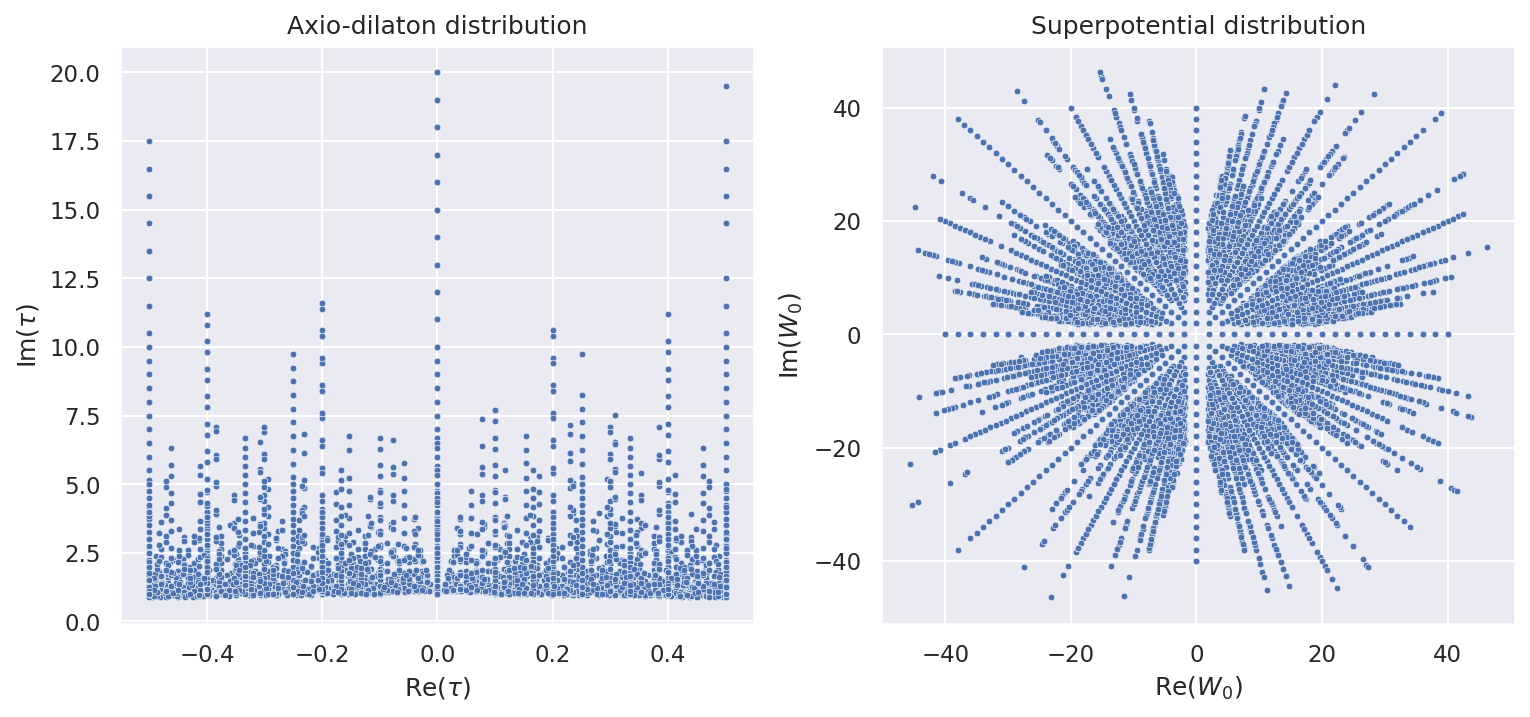

In [21]:
fig,ax = plt.subplots(1,2,figsize=(12,5),dpi=150)
sn.scatterplot(x = tau_values.real, y = tau_values.imag,ax=ax[0],s=10)
sn.scatterplot(x = W_values.real, y = W_values.imag,ax=ax[1],s=10)
ax[0].set_xlabel(r"$\mathrm{Re}(\tau)$")
ax[0].set_ylabel(r"$\mathrm{Im}(\tau)$")
ax[1].set_xlabel(r"$\mathrm{Re}(W_0)$")
ax[1].set_ylabel(r"$\mathrm{Im}(W_0)$")
ax[0].set_title("Axio-dilaton distribution")
ax[1].set_title("Superpotential distribution")
plt.show()

We can zoom in into the above plots to see more structures:

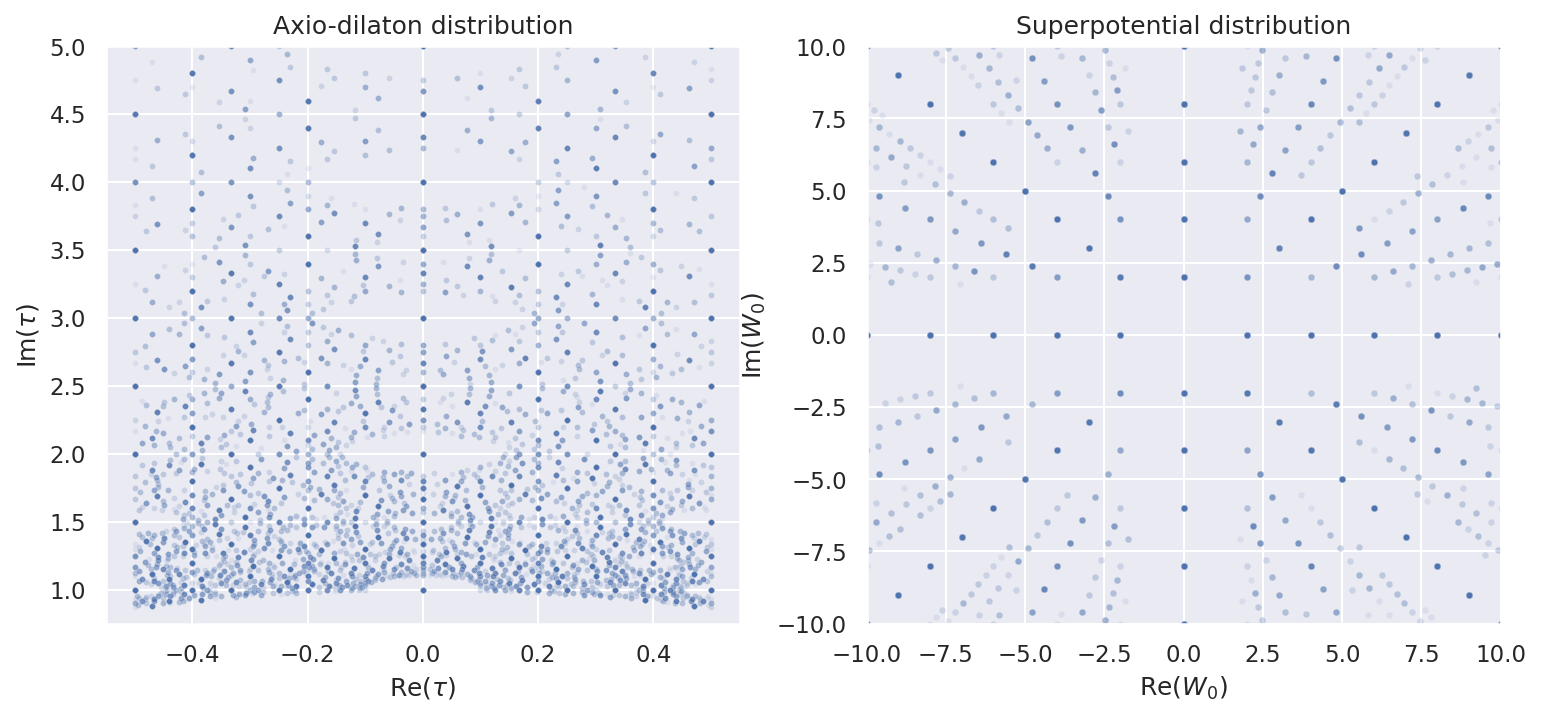

In [22]:
fig,ax = plt.subplots(1,2,figsize=(12,5),dpi=150)
sn.scatterplot(x = tau_values.real, y = tau_values.imag,ax=ax[0],s=8,alpha=0.1)
sn.scatterplot(x = W_values.real, y = W_values.imag,ax=ax[1],s=10,alpha=0.1)
ax[0].set_ylim(0.75,5)
ax[1].set_ylim(-10,10)
ax[1].set_xlim(-10,10)
ax[0].set_xlabel(r"$\mathrm{Re}(\tau)$")
ax[0].set_ylabel(r"$\mathrm{Im}(\tau)$")
ax[1].set_xlabel(r"$\mathrm{Re}(W_0)$")
ax[1].set_ylabel(r"$\mathrm{Im}(W_0)$")
ax[0].set_title("Axio-dilaton distribution")
ax[1].set_title("Superpotential distribution")
plt.show()

We observe non-trivial features in the two distributions.
Specifically, the distribution for the axio-dilaton shows the following features:
* **voids**: there are isolated points surrounded by rather large voids. The latter actually scale with the maximum tadpole `Qmax` used above to generate the datasets.
* **clusters**: Isolated points are also highly populated as we can see by the transparency of the individual points above.

We can also plot the flux quanta in our dataset

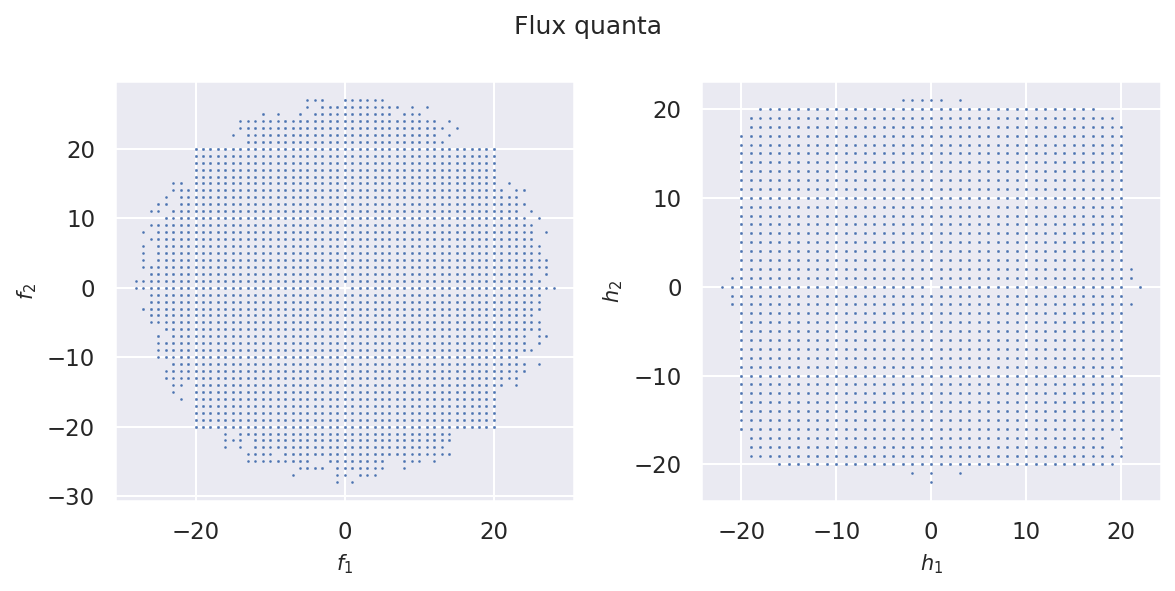

In [62]:
fig,ax = plt.subplots(1,2,figsize=(8,4),dpi=150)
       
sn.scatterplot(x=fluxes[:,0],y=fluxes[:,1],s=ss,ax=ax[0]);
ax[0].set(xlabel='$f_1$', ylabel='$f_2$')
ax[0].xaxis.get_label().set_fontsize(fss)
ax[0].yaxis.get_label().set_fontsize(fss)

sn.scatterplot(x=fluxes[:,2],y=fluxes[:,3],s=ss,ax=ax[1]);
ax[1].set(xlabel='$h_1$', ylabel='$h_2$')
ax[1].xaxis.get_label().set_fontsize(fss)
ax[1].yaxis.get_label().set_fontsize(fss)

fig.suptitle('Flux quanta in our dataset',fontsize=fs)

plt.tight_layout()
plt.savefig(path_figs+"fluxes.png",format="png",dpi=200, bbox_inches='tight')
plt.show()

### Unsupervised Learning 

Unsupervised learning is a subfield of ML that aims to uncover patterns, structures, or latent information in **unlabelled** data. In contrast to supervised learning, which depends on labelled input-output pairs to train a model, unsupervised learning operates solely on input data, striving to identify intrinsic structures, groupings, or representations. This renders unsupervised learning particularly powerful in fields where labelled data are scarce or costly to obtain. In mathematical terms, let $\mathcal{D} = \{\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_N\}$ denote a dataset consisting of $N$ observations, where each $\mathbf{x}_i \in \mathbb{R}^d$ is an $d$-dimensional vector. The objective of unsupervised learning is to extract meaningful information $\mathbf{z}_i$ about the data, which may represent cluster labels, reduced dimensions, or latent variables within a generative model.

Here, we briefly discuss two methods belonging to the category of dimensionality reduction. Dimensionality reduction aims to project high-dimensional data into a lower-dimensional space while preserving its essential structure. This is particularly useful in physics, where datasets (e.g., particle collision data, string vacua) can have thousands of features. Formally, given a dataset $\mathcal{D}$, dimensionality reduction finds a mapping $f: \mathbb{R}^d \to \mathbb{R}^m$, where $m \ll d$, such that the projected data $z_i = f(x_i)$ retains the structure of $\mathcal{D}$. 
We mention two common techniques: 
- **Principal Component Analysis** (PCA) which projects data along the directions of maximum variance, determined by the eigenvectors of the covariance matrix. This is by far the most popular dimensionality reduction algorithm. It first identifies the hyperplane that lies closest to the data and then projects the data onto this hyperplane. Generally, it is preferable to select the number of dimensions that account for a sufficiently large proportion of the variance (e.g., 95%). After dimensionality reduction, the training set occupies much less space. Thus, while most of the variance is retained, the dataset is reduced to a small fraction of its original size. This compression ratio is reasonable, and one can appreciate how such reduction can significantly accelerate an algorithm.
- **t-Distributed Stochastic Neighbour Embedding** (t-SNE) which is a non-linear method that preserves local relationships in the data, often used for visualisation. In other words, this method reduces dimensionality while attempting to maintain similar instances close together and dissimilar instances farther apart. It is predominantly employed for visualisation, particularly to display clusters of instances in high-dimensional space.

Applications in Physics are e.g. reducing dimensionality of detector outputs in high-energy physics while retaining meaningful correlations, or exploring relationships in the string landscape, such as clustering Calabi-Yau manifolds based on reduced topological data.
In ML, the aforementioned techniques mitigate the curse of dimensionality and enhance computational efficiency when training neural networks. By retaining the most meaningful features (PCA) or preserving local and global data structures (t-SNE), these methods improve model performance and facilitate the visualisation and interpretation of high-dimensional data.

#### Dimensional reduction using PCA

To reiterate, **Principal Component Analysis** (PCA) is widely used for dimensionality reduction, enabling researchers to visualise high-dimensional datasets and identify key features. In the context of the string landscape, PCA can simplify datasets of compactifications or flux configurations, highlighting dominant patterns that might correspond to physically relevant vacua.

In the context of flux vacua, an interesting question concerns the effictive dimension of the choices of fluxes. To find out, we use the `PCA` function implemented in `sklearn.decomposition` and fit it on the above dataset of fluxes as follows:

In [25]:
# Import PCA
from sklearn.decomposition import PCA 

# Load PCA
pca = PCA()

# Fit PCA
pca.fit(fluxes);

The variance ratio and principal components (PC) are the obtained as follows:

In [25]:
print("Variance: ",np.round(pca.explained_variance_ratio_,2))
print("1st PC: ",np.round(pca.components_[0],2))
print("2nd PC: ",np.round(pca.components_[1],2))
print("3rd PC: ",np.round(pca.components_[2],2))
print("4th PC: ",np.round(pca.components_[3],2))

Variance:  [0.48 0.48 0.02 0.02]
1st PC:  [ 0.83 -0.07  0.05  0.56]
2nd PC:  [ 0.07  0.83 -0.56  0.05]
3rd PC:  [-0.53 -0.18 -0.27  0.78]
4th PC:  [-0.18  0.53  0.78  0.27]


The effective dimension of our data can be obtained as follows:

In [26]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

2

Here we require that 95% of variance is explained by the dimesnionally reduced dataset. It turns out that taking only the two dominating principal components is sufficient because the explain 98% of the variance. Said differently, our original 4D dataset can be desribed by a 2D dataset defined by two major principal components.

To show that this saves us some memory, we first transform the data

In [57]:
# Transformed dataset
X_trafo=pca.transform(fluxes)

# Keep only the first two columns 
X_trafo = X_trafo[:,:2]

# Computing memory usage of arrays
size_f = np.around(fluxes.nbytes/10**6,2)
size_X = np.around(X_trafo.nbytes/10**6,2)

print(f"Size of 4D array: {size_f}MB")
print(f"Size of 2D array: {size_X}MB")

Size of 4D array: 4.7MB
Size of 2D array: 2.35MB


We see that the dimensional reduction saved us a factor of 2 in memory.

Next, let us make plots for the above output:

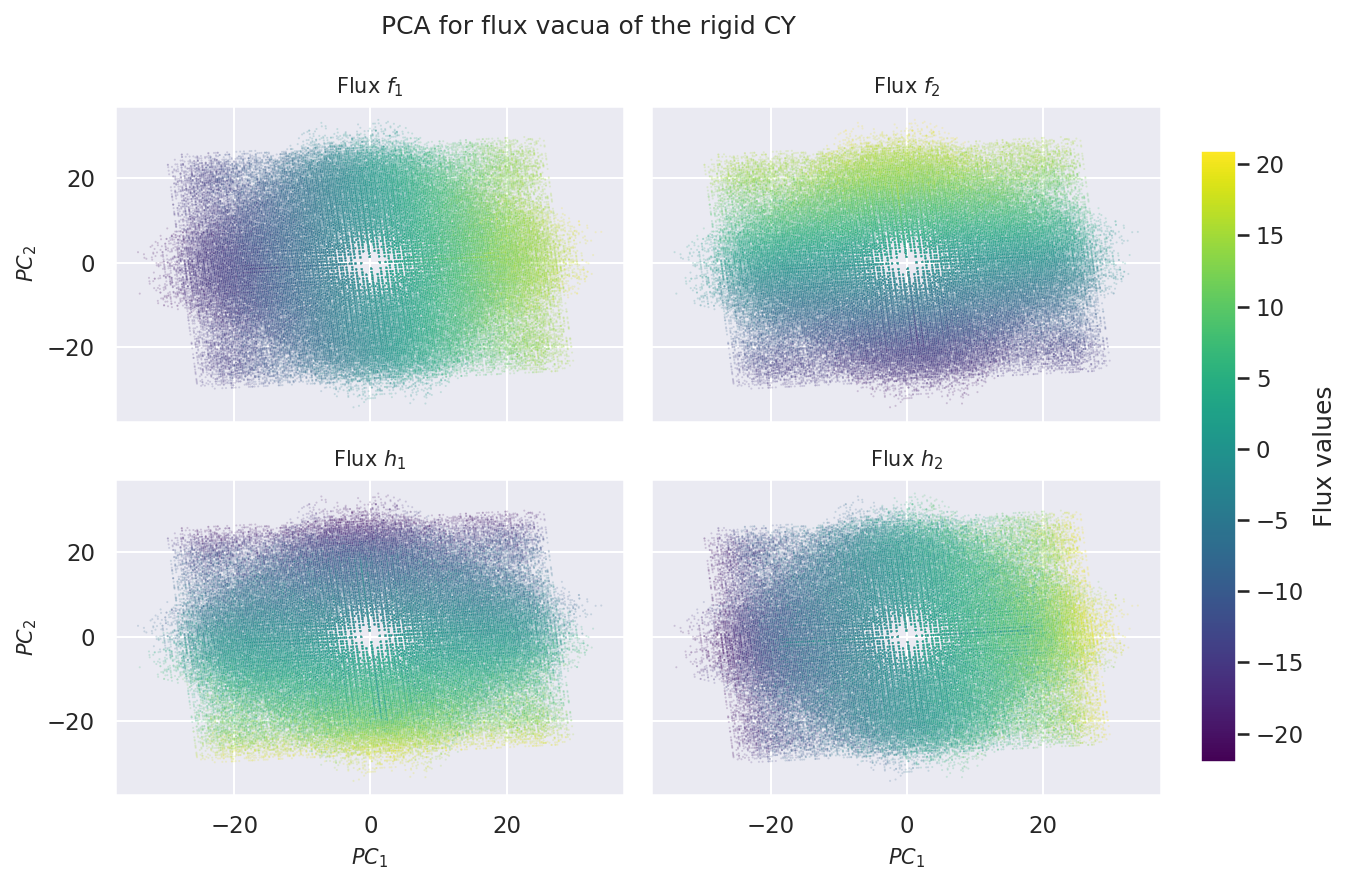

In [63]:
fig,ax = plt.subplots(2,2,figsize=(8,6),dpi=150)
for k in range(NumFluxes):
    
    flux_ID=k+1
    
    if k<2:
        I1=0
        I2=k
    else:
        I1=1
        I2=k-2
        
    sn.scatterplot(x=X_trafo[:,0],y=X_trafo[:,1],s=ss-1,alpha=0.2,c=fluxes[:,flux_ID-1],cmap=cmap,legend=False,ax=ax[I1][I2]);
    ax[I1][I2].set(xlabel='$PC_1$', ylabel='$PC_2$')
    ax[I1][I2].xaxis.get_label().set_fontsize(fss)
    ax[I1][I2].yaxis.get_label().set_fontsize(fss)
    if I1==0:
        ax[I1][I2].set_title(r'Flux $f_{'+str(I2+1)+'}$',fontsize=fsss)
    else:
        ax[I1][I2].set_title(r'Flux $h_{'+str(I2+1)+'}$',fontsize=fsss)
    
    if I1!=1:
        ax[I1][I2].set(xticklabels=[])  # remove the tick labels
        ax[I1][I2].set(xlabel=None)
    if I2!=0:
        ax[I1][I2].set(yticklabels=[])  # remove the tick labels
        ax[I1][I2].set(ylabel=None)


norm = plt.Normalize(min(fluxes.T[flux_ID-1]),max(fluxes.T[flux_ID-1]))
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)

fig.suptitle('PCA for flux vacua of the rigid CY',fontsize=fs)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.01, 0.15, 0.03, 0.68])
cbar=fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Flux values',fontsize=fs)

plt.tight_layout()
plt.savefig(path_figs+"PCA.png",format="png",dpi=200, bbox_inches='tight')
plt.show()

Note that, while our input consisted of integer flux vectores living in some sub-lattice of $\mathbb{Z}^4$ (recall the figure from above),
the shape of the dimensionally reduced dataset resembles that of an *octagon* with a void near the origin. 
By further inspecting the data, one might be able to better understand the origin of these structures. 
In interest of time, we leave this as an exerise.

#### Visualisation using t-SNE 

As mentioned above, **t-Distributed Stochastic Neighbour Embedding** (t-SNE) is another dimensionality reduction technique, particularly effective for visualising clusters in high-dimensional data. When applied to Calabi-Yau datasets or other string-theoretic configurations, t-SNE can reveal natural groupings, such as families of manifolds with similar topological features.

We again apply the t-SNE algorithm to the dataset of fluxes:

In [85]:
from sklearn.manifold import TSNE
if False:
    #X_trafo = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(fluxes).T
    X_trafo = TSNE(n_components=2, learning_rate='auto',init='pca', perplexity=10).fit_transform(fluxes).T
    save_zipped_pickle((fluxes,X_trafo,W_values),path_files + "tsne_fit.p")

The transformation can take a while. For convenience, we load a precompiled version instead:

In [86]:
fluxes0,X_trafo0,W_values0 = load_zipped_pickle(path_files + "tsne_fit.p")

Let us visualise the resulting data

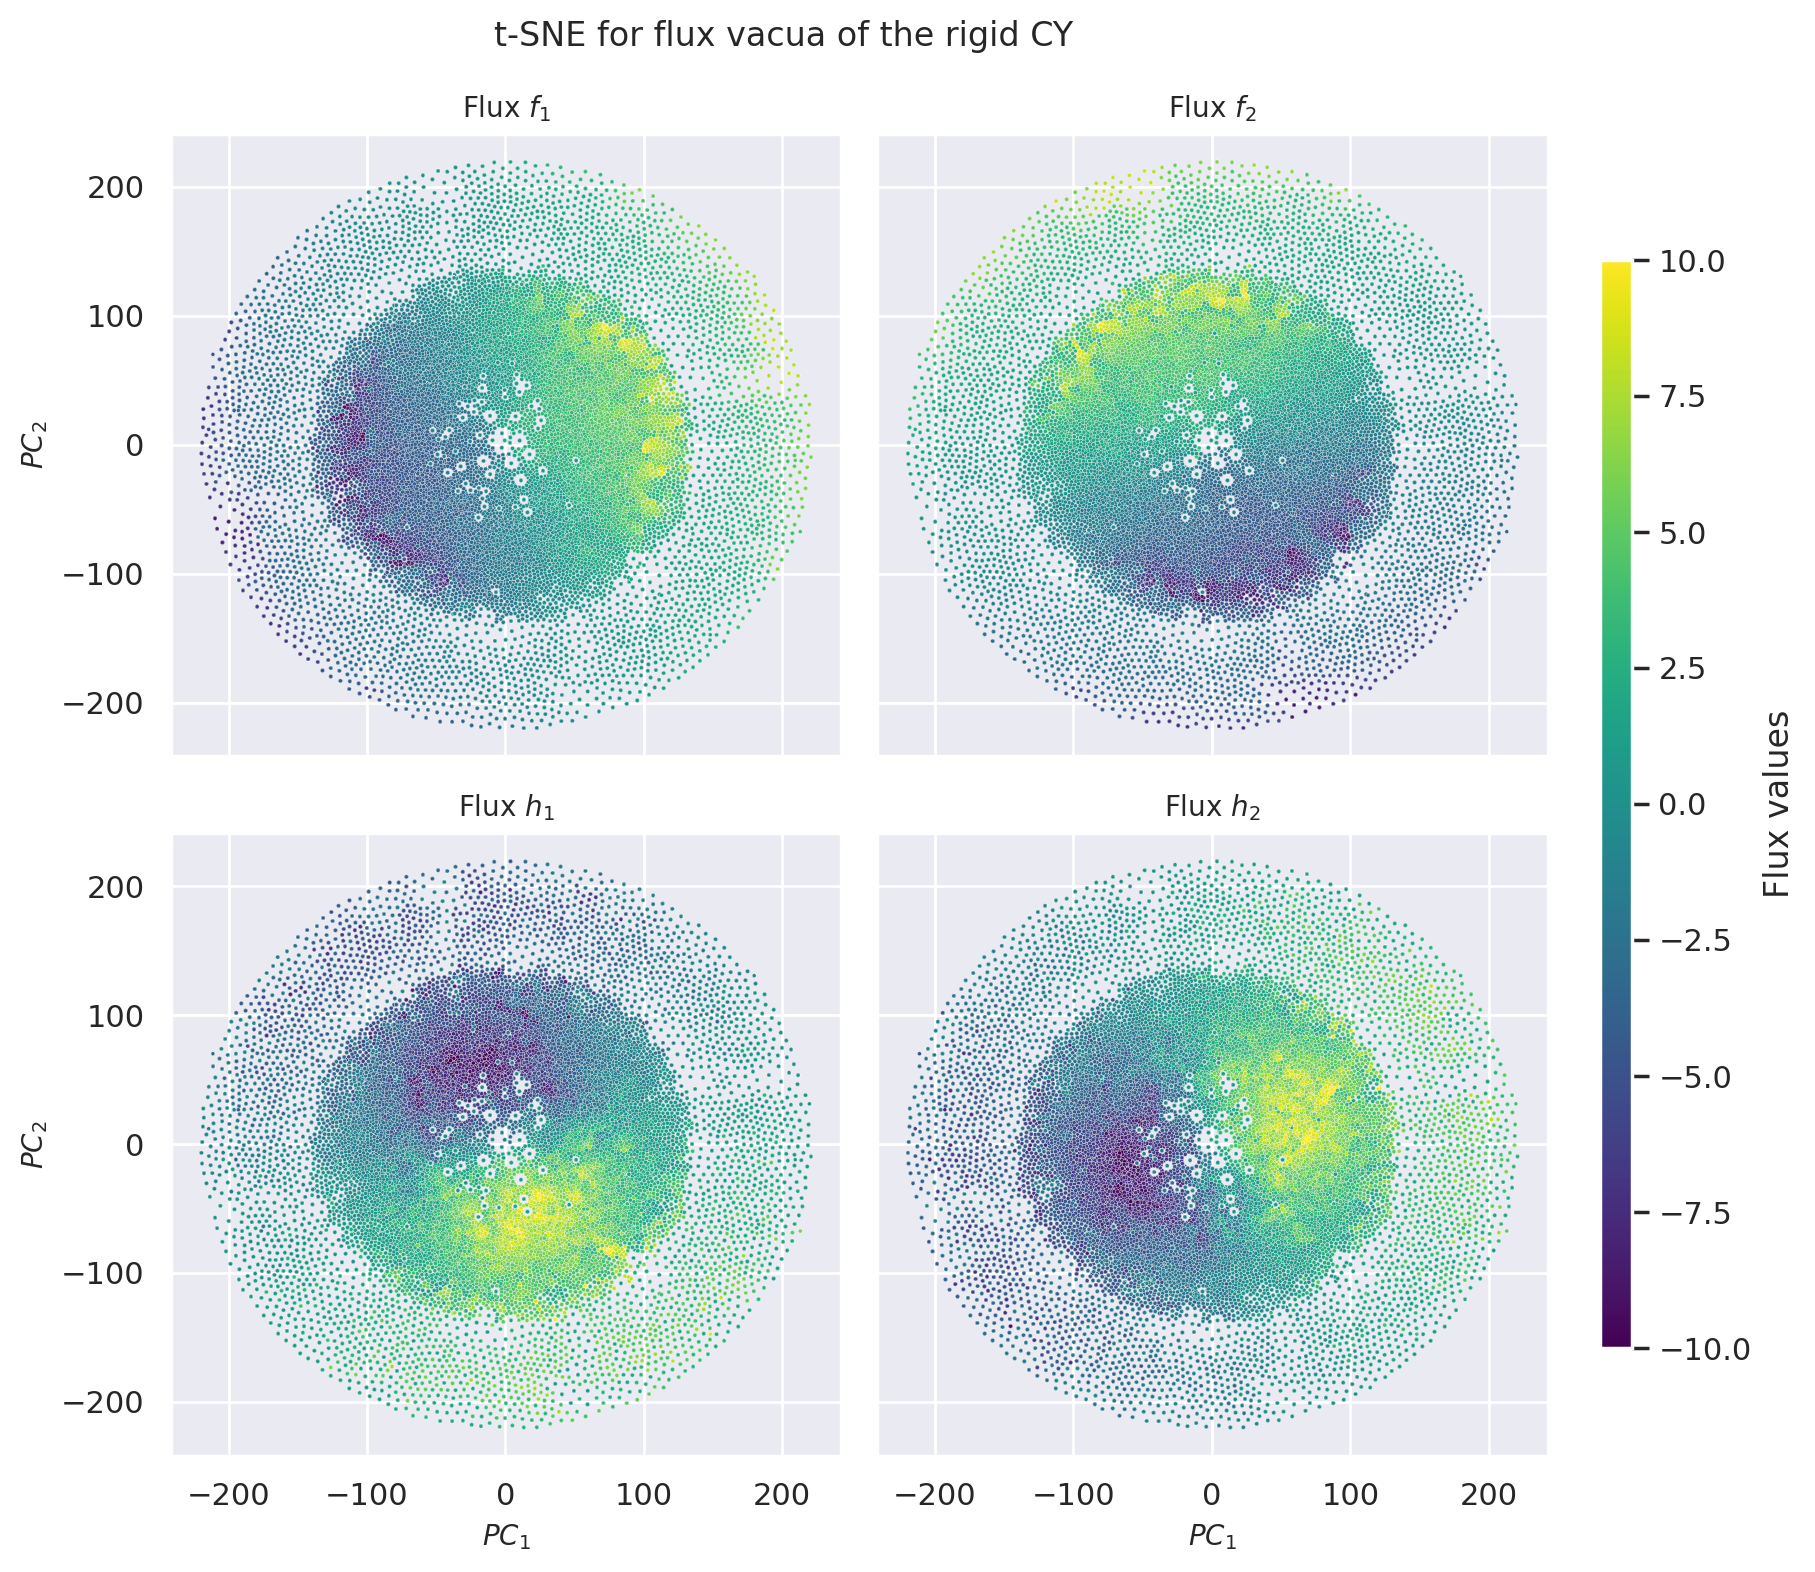

In [87]:
fig,ax = plt.subplots(2,2,figsize=(8,8),dpi=200)
for k in range(NumFluxes):
    
    flux_ID=k+1
    
    if k<2:
        I1=0
        I2=k
    else:
        I1=1
        I2=k-2
        
    sn.scatterplot(x=X_trafo0[0],y=X_trafo0[1],s=ss,c=fluxes0.T[flux_ID-1],cmap=cmap,legend=False,ax=ax[I1][I2]);
    ax[I1][I2].set(xlabel='$PC_1$', ylabel='$PC_2$')
    ax[I1][I2].xaxis.get_label().set_fontsize(fss)
    ax[I1][I2].yaxis.get_label().set_fontsize(fss)
    if I1==0:
        ax[I1][I2].set_title(r'Flux $f_{'+str(I2+1)+'}$',fontsize=fsss)
    else:
        ax[I1][I2].set_title(r'Flux $h_{'+str(I2+1)+'}$',fontsize=fsss)
    
    if I1!=1:
        ax[I1][I2].set(xticklabels=[])  # remove the tick labels
        ax[I1][I2].set(xlabel=None)
    if I2!=0:
        ax[I1][I2].set(yticklabels=[])  # remove the tick labels
        ax[I1][I2].set(ylabel=None)


norm = plt.Normalize(min(fluxes0.T[flux_ID-1]),max(fluxes0.T[flux_ID-1]))
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.01, 0.15, 0.02, 0.68])
cbar=fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Flux values',fontsize=fs)

fig.suptitle('t-SNE for flux vacua of the rigid CY',fontsize=fs)

plt.tight_layout()
#plt.savefig(path_figs+"TSNE.png",format="png",dpi=200, bbox_inches='tight')
plt.show()

The t-SNE result shows clear differences to the PCA result. We find
- isolated clusters highlighted in the center through smaller viods,
- dense ball of solutions in the center surrounded by a prominant ring, and
- correlations of the reduced dataset with respect to the individual flux numbers.

It is also interesting to color-code the above plots by $W_0$:

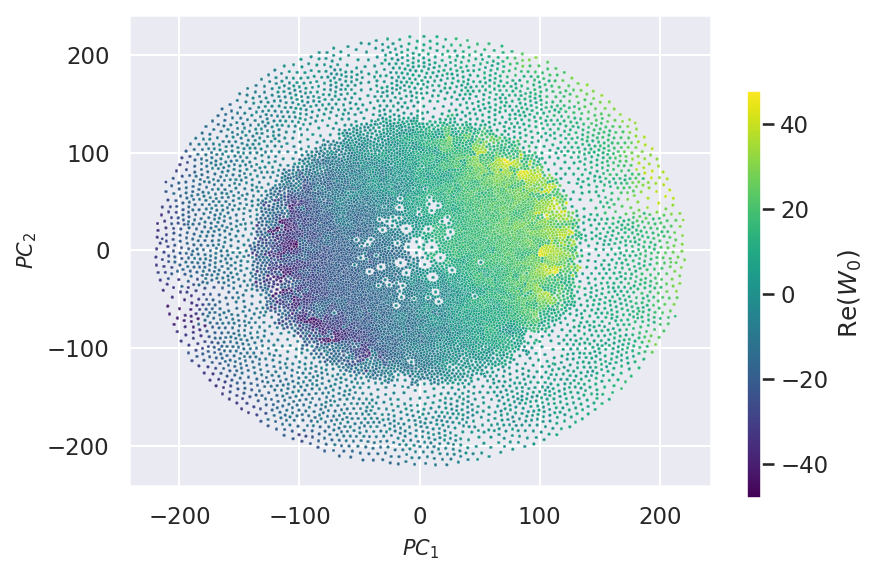

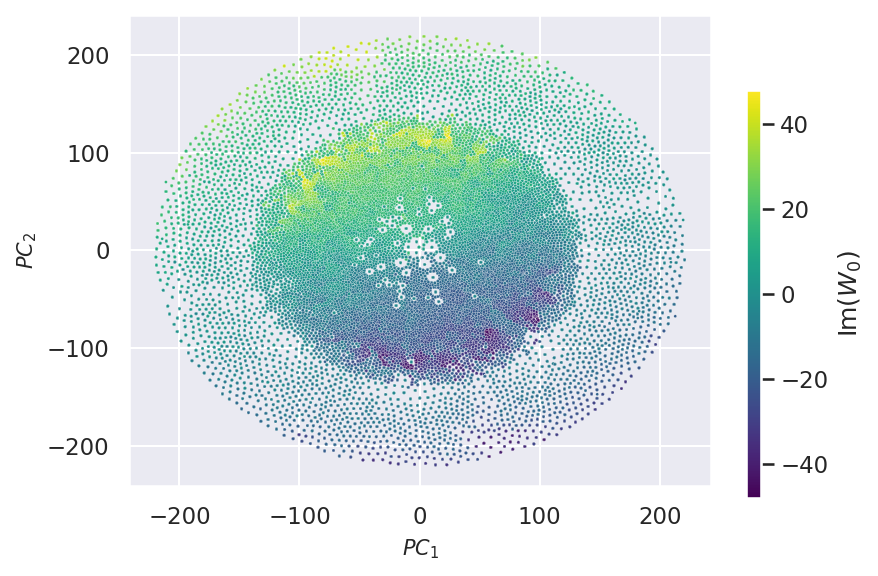

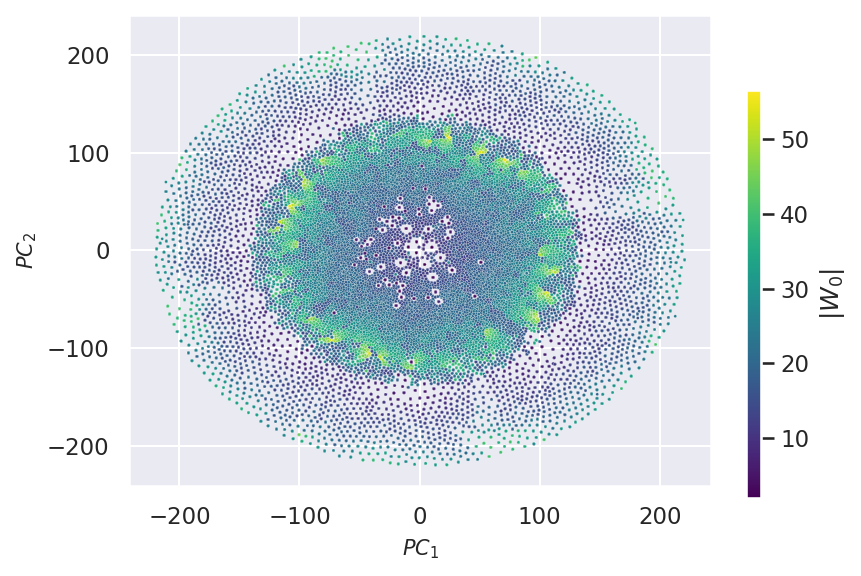

In [89]:
hues = [W_values0.real,W_values0.imag,np.abs(W_values0)]
files = ["TSNE_ReW.png","TSNE_ImW.png","TSNE_AbsW.png"]
labels = [r'$\mathrm{Re}(W_0)$',r'$\mathrm{Im}(W_0)$',r'$|W_0|$']
for i in range(len(files)):
    hue = hues[i]
    file = files[i]
    label = labels[i]

    fig = plt.figure(figsize=(5,4),dpi=150)
    sn.scatterplot(x=X_trafo0[0],y=X_trafo0[1],s=ss,c=hue,cmap=cmap,legend=False)
    plt.xlabel('$PC_1$',fontsize=fss)
    plt.ylabel('$PC_2$',fontsize=fss)
    norm = plt.Normalize(min(hue),max(hue))
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    cbar_ax = fig.add_axes([1.01, 0.15, 0.02, 0.68])
    cbar=fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label(label,fontsize=fs)

    plt.tight_layout()
    plt.savefig(path_figs+file,format="png",dpi=200, bbox_inches='tight')
    plt.show()

Again, we notice that the distribution scales with $\text{Re}(W_0)$, $\text{Im}(W_0)$ and $|W_0|$.

## 1. Learning moduli VEVs

A promising application of NNs lies in solving or approximating differential or algebraic equations that arise in string theory. As we will demonstrate explicitly in this section, NNs can be trained on approximating solutions to the equations governing moduli stabilisation. By interpreting NNs as function approximators, they can replace traditional numerical solvers, which are often constrained by computational resources and problem-specific tuning. In the context of string theory, where the equations frequently involve high-dimensional or non-linear components, NNs offer a scalable and adaptable alternative. In essence, NNs as function learners act as powerful surrogates, bridging the gap between theoretical predictions and practical computations in the challenging terrain of string theory.


In this context, the rigid Calabi-Yau manifold serves as a valuable toy model, providing a simplified framework that offers the following advantages:  
- **Efficient Data Generation**: It enables us to generate arbitrarily large training datasets with minimal computational effort, thereby facilitating a robust exploration of ML methodologies.  
- **Analytic Benchmarking**: The analytic solution, given by $$\langle\tau\rangle = \frac{f_1 - \mathrm{i}f_2}{h_1 - \mathrm{i}h_2}\, ,$$ is well-known and provides a precise reference against which the ML models can be tested.  

This straightforward application allows us to systematically experiment with various ML implementations and rigorously assess their efficacy in learning the vacuum expectation values of moduli in flux compactifications. By first focusing on this relatively simple scenario, we can gain critical insights and refine our techniques before extending them to more intricate and realistic examples within the landscape of string theory compactifications.  

### Training and test data

We start by preparing the data for supervised learning:

In [11]:
# Define input = fluxes
X0 = fluxes

# Define output = moduli VEVs
y0 = np.append([tau_values.real],[tau_values.imag],axis=0).T

# Print shape of input and output
X0.shape, y0.shape

((20064, 4), (20064, 2))

We now have to keep in mind that the two arrays `X0` and `y0` typically have completely different entries.
Especially for fluxes which are integers, it is highly recommended to rescale them to floats which leads 
to much better performance when training NNs. We achieve this by running the following lines

In [12]:
from sklearn.preprocessing import RobustScaler

# Rescale X
transformer = RobustScaler()
transformer_X = transformer.fit(X0)
X = transformer_X.transform(X0)

# Rescale y
transformer = RobustScaler()
transformer_y = transformer.fit(y0)
y = transformer_y.transform(y0)

Next, we split the dataset into training and test data with the following logic in mind:
* **Training data** is the subset of the dataset used to train a machine learning model. It contains input-output pairs (in supervised learning) or input features (in unsupervised learning), allowing the model to learn patterns, relationships, or representations from the data. During this phase, the model adjusts its parameters iteratively to minimise errors and improve its predictive accuracy.
* **Test data**, on the other hand, is a separate subset of the dataset used to evaluate the performance of the trained model. This data is unseen during the training phase and serves as a proxy for how well the model will generalise to new, real-world data. By measuring metrics such as accuracy, precision, recall, or mean squared error on the test data, practitioners can assess the model’s effectiveness and detect issues like overfitting or underfitting.

We can use pre-implemented function in `sklearn.model_selection` choosing here a 20% split between test (20%) and training (80%) data:

In [13]:
from sklearn.model_selection import train_test_split

# Perform splitting
train_data, test_data, train_label, test_label = train_test_split(X, y, test_size=0.2, random_state=0)

# Print info
print("Length data set:",len(X))
print("Length training data set:",len(train_data))
print("Length test data set:",len(test_data))

Length data set: 20064
Length training data set: 16051
Length test data set: 4013


Below, these two sets will be used for training and subsequent evaluation of the performance of our architectures.

### Baseline model testing

Before leveraging advanced AI tools, it's good practice to establish a baseline. 
This involves using simple, readily available models from prominent machine learning and optimization libraries.
In this section, we will focus on three well-established models for simplicity:

1. **Linear Regression**: 
Linear regression is a statistical model that estimates the linear relationship between a dependent variable 
(response) and one or more independent variables (predictors). 

2. **Polynomial Regression**:
Polynomial regression is an extension of linear regression, where the relationship between the independent variable(s) 
and the dependent variable is modeled as an nth-degree polynomial. 
It is particularly useful when the data shows a nonlinear relationship.

3. **Random Forest**:
Random forest is an ensemble learning method for both classification and regression tasks. It operates by constructing multiple decision trees during training. 
For classification tasks, it outputs the class chosen by the majority of the trees.
For regression tasks, it computes the average of predictions from all trees.
Random forests address the issue of overfitting often encountered with individual decision trees.

In the calculations below, you can easily add more methods using libraries like `sklearn`.


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures


# Get quadratic polynomial features
poly_features = PolynomialFeatures(degree=2, include_bias=False)

# Build custom class for polynomial regression
class poly_reg(LinearRegression):
    
    def __init__(self):
        
        super(poly_reg, self).__init__()
        
        self.linear_regression = LinearRegression()
        
    def predict(self,data):
        
        return self.linear_regression.predict(poly_features.fit_transform(data))
    
    def fit(self,data,labels):
        
        return self.linear_regression.fit(poly_features.fit_transform(data),labels)


# Collect models from `sklearn`
baseline_models = {
    'Linear regression': LinearRegression(),
    'Polynomial regression': poly_reg(),
    'Random forest': RandomForestRegressor(),
} 

We are now ready to fit the above models to our data

In [15]:
# Fit the models on training data
for name, model in tqdm(baseline_models.items()):
    model.fit(train_data, train_label)

  0%|          | 0/3 [00:00<?, ?it/s]

To quantify accuracy of the models, we evaluate different metrics:

                       r2_score       MAE       MSE
Linear regression      0.001214  0.709540  1.275921
Polynomial regression  0.676354  0.359531  0.355920
Random forest          0.955840  0.054437  0.016751


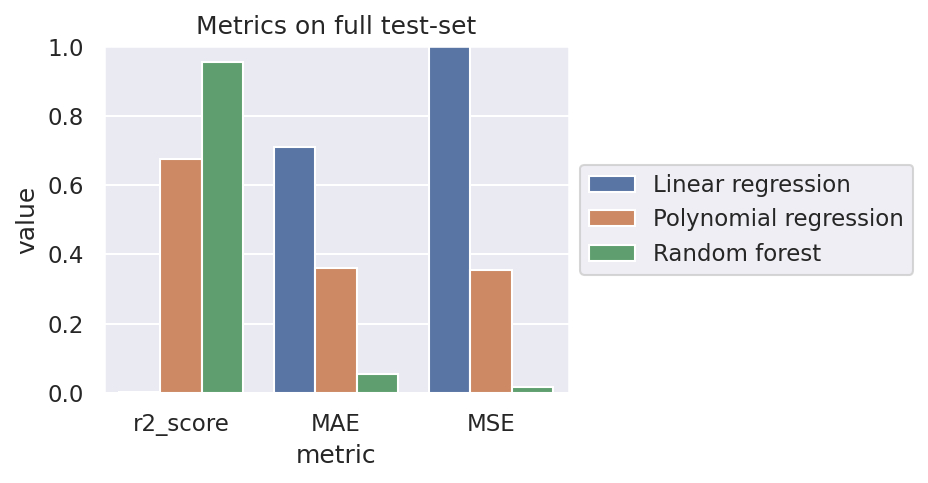

In [16]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# Define metrics
metrics = {
    'r2_score': r2_score,
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error,
    
}

# Evaluate metrics for different models on test data
baseline_evaluations = pd.DataFrame({
    metric_name: {
        model_name: metric(test_label, model.predict(test_data))
        for model_name, model in baseline_models.items()
    }
    for metric_name, metric in metrics.items()
})

# Print baseline evaluation
print(baseline_evaluations)

# Make figure for metrics
fig = plt.figure(figsize=(4,3),dpi=150)

baseline_evaluations_tidy = (
    baseline_evaluations
    .reset_index()
    .rename({"index": "model"}, axis=1)
    .melt(id_vars=["model"], var_name="metric")
)
sn.barplot(data=baseline_evaluations_tidy, x="metric", y="value", hue="model")
plt.ylim(0, 1)
plt.title("Metrics on full test-set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The metrics quantify how well the different models do in solving the task at hand. As expected, linear regressions fails miserably because 
the function that we are trying to learn is simply non-linear. In contrast, random forest works splendidly with small MSE and high r2-score.

There is also a qualitative way to evluate the performance of the different models. Namely, we can plot the predicted values 
against the true values and in this way, see the qualitative differences in our baseline models:

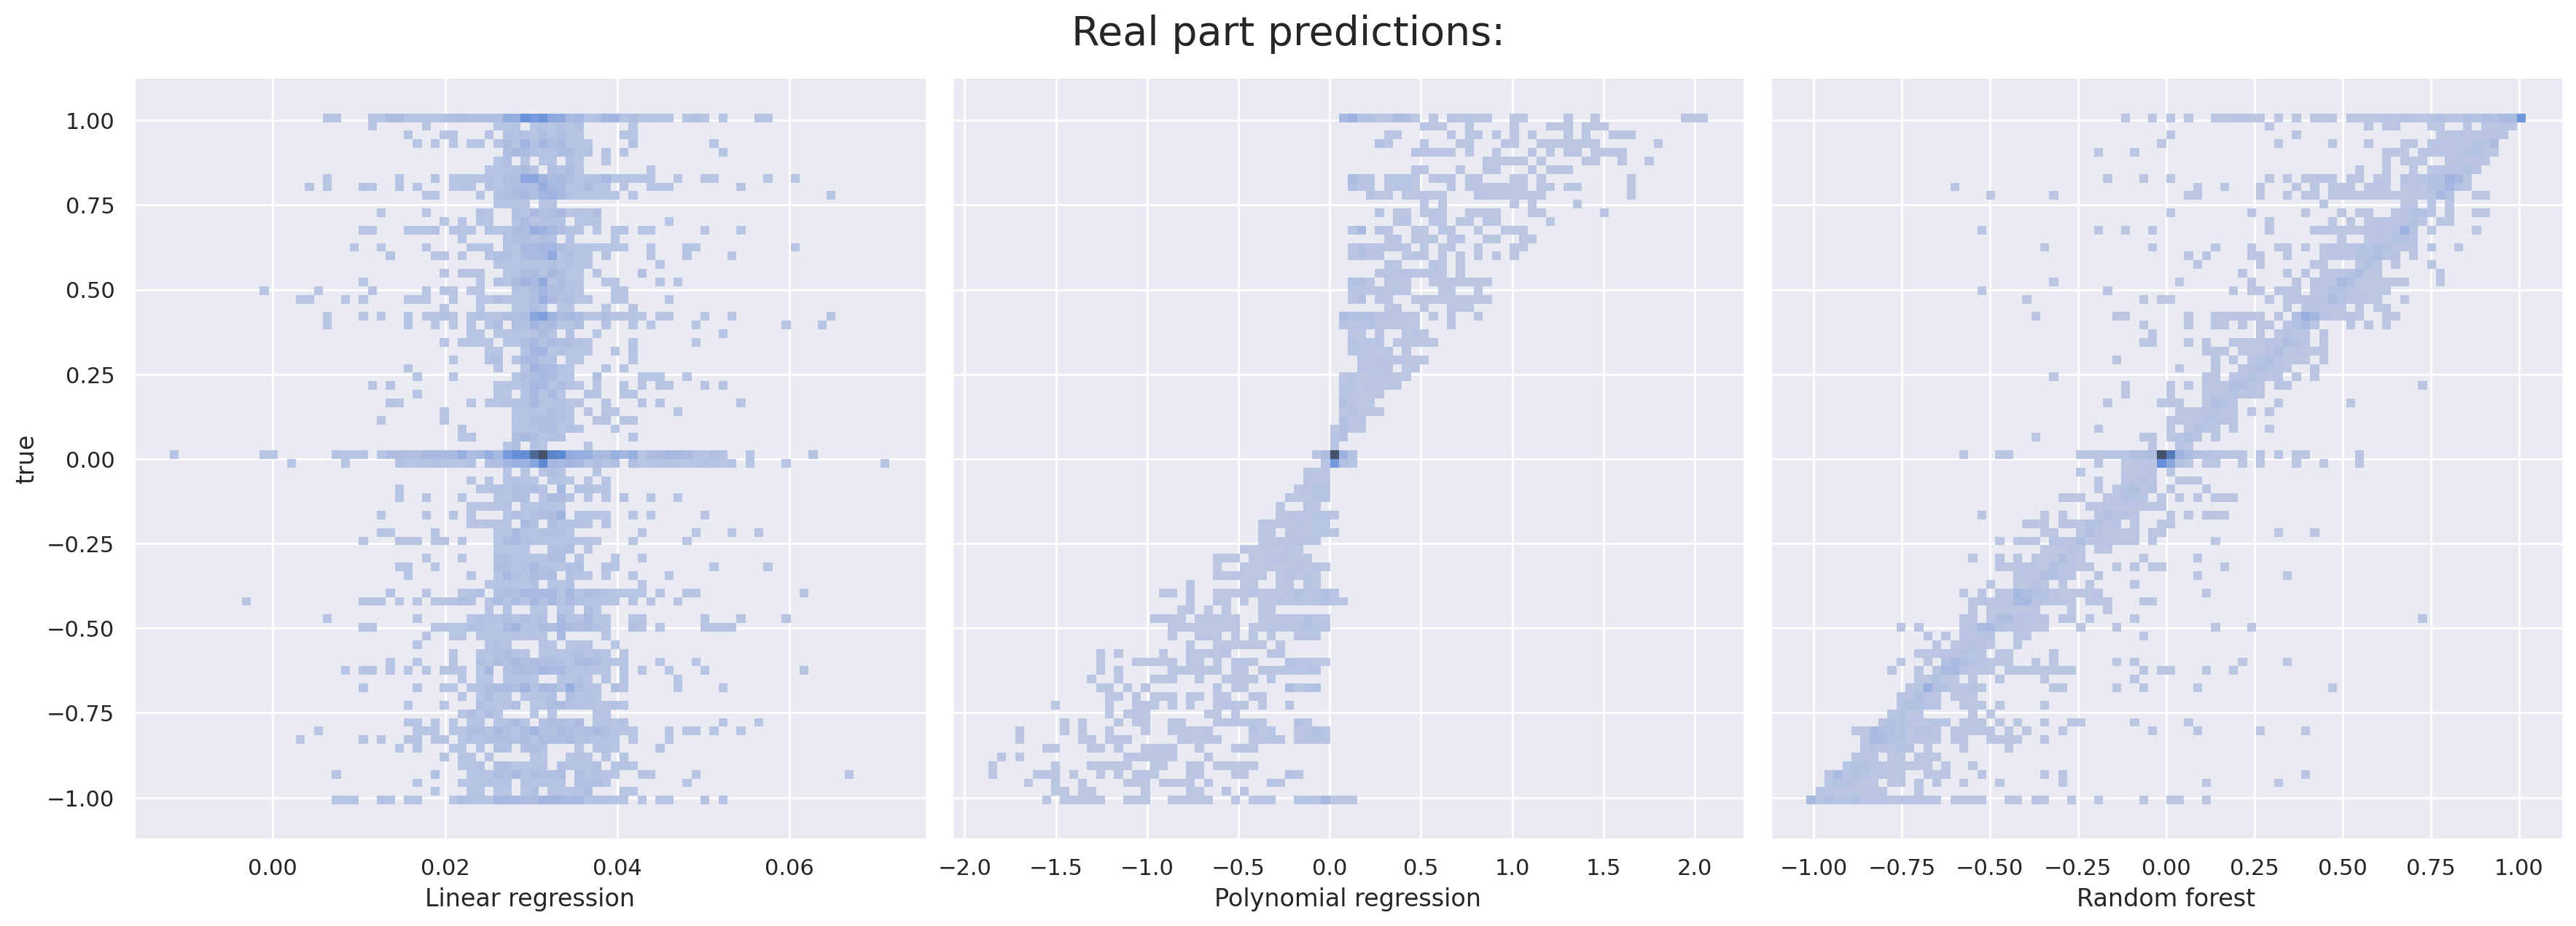

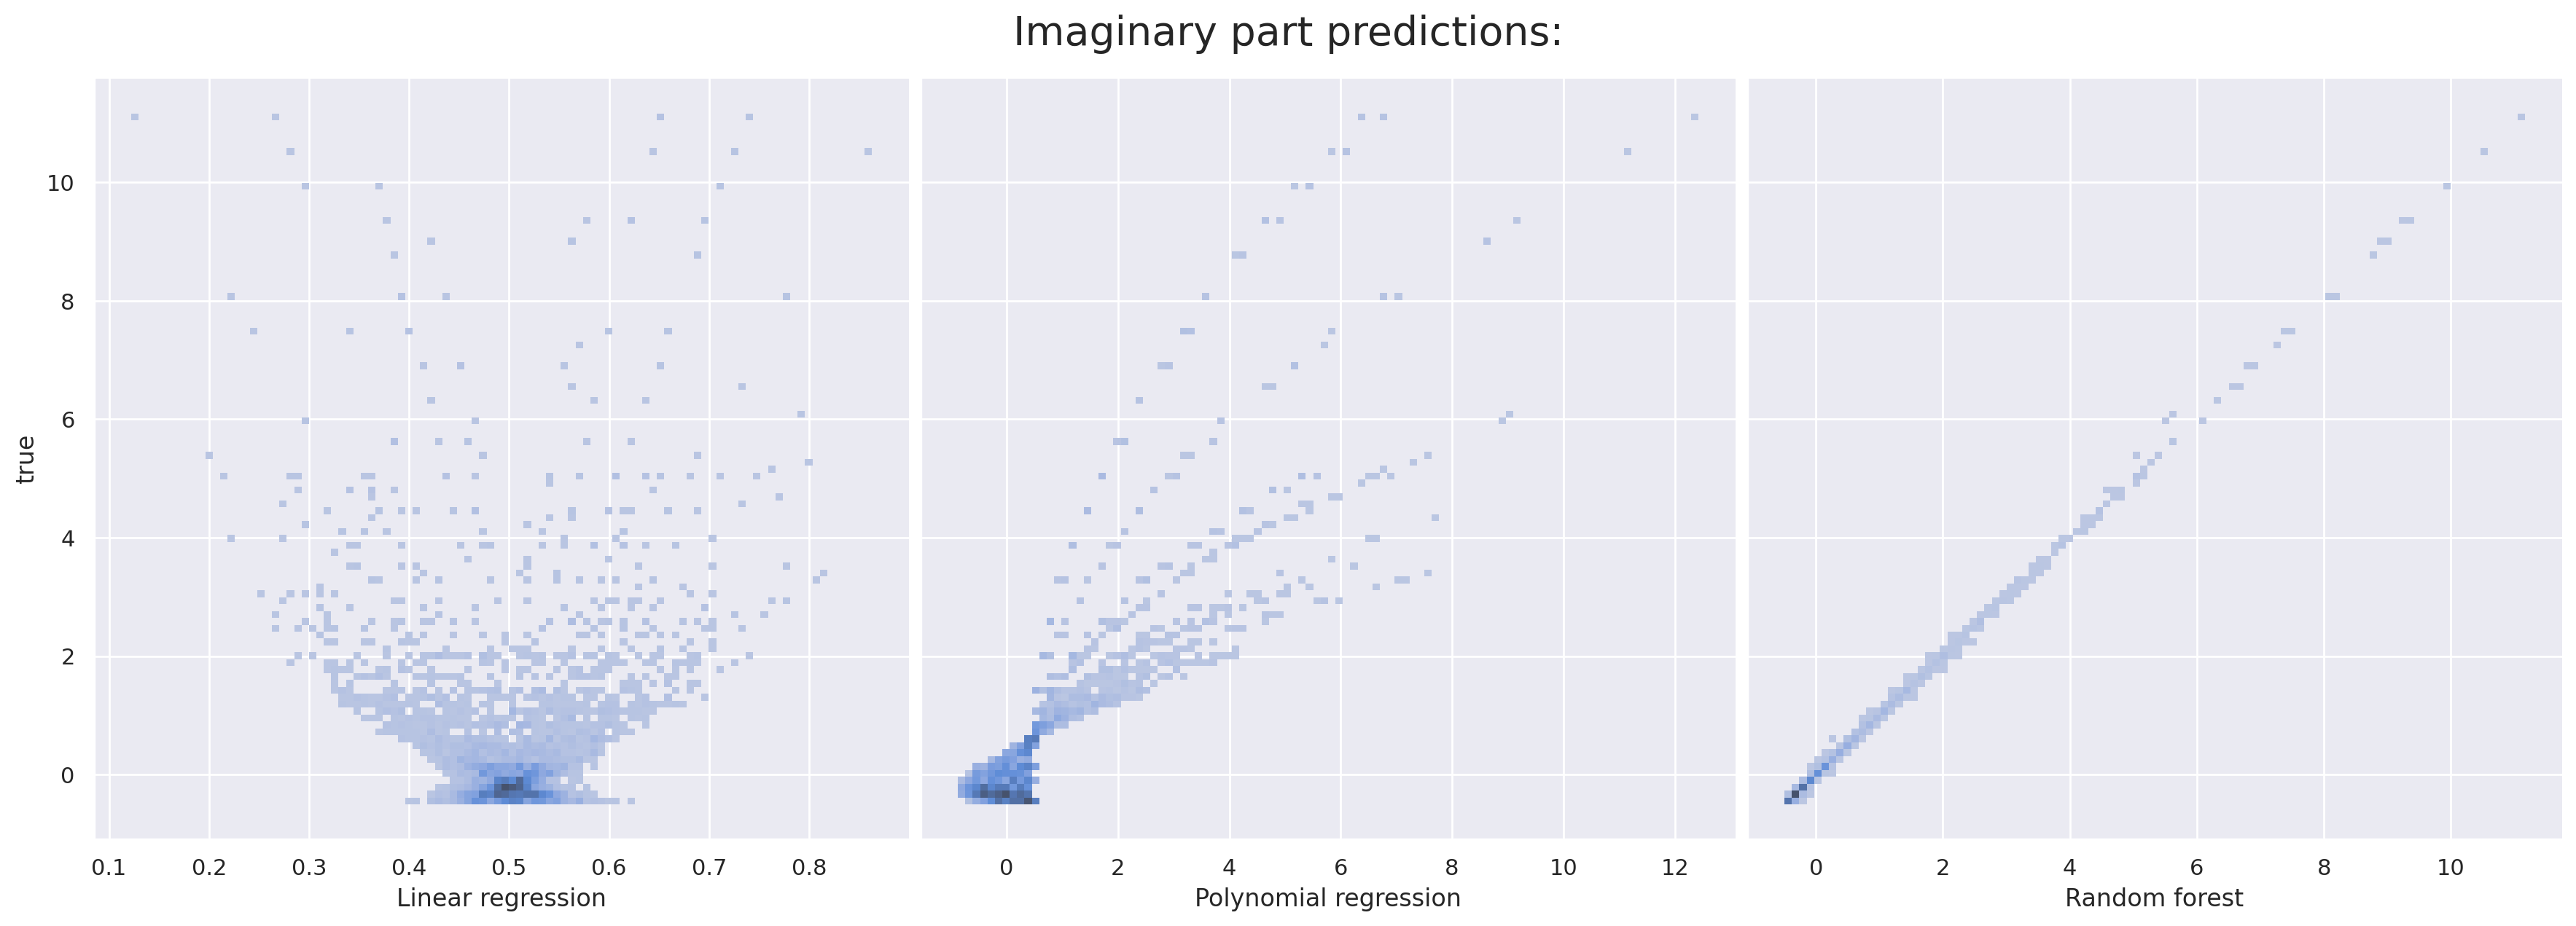

In [17]:
# Get baseline predicton for the test data -> real part
baseline_predictions_RE = pd.DataFrame({
    name: model.predict(test_data)[:,0]
    for name, model in baseline_models.items()
})

# Get baseline predicton for the test data -> imaginary part
baseline_predictions_IM = pd.DataFrame({
    name: model.predict(test_data)[:,1]
    for name, model in baseline_models.items()
})

# Add labels
baseline_predictions_RE["true"] = test_label[:,0]
baseline_predictions_IM["true"] = test_label[:,1]

g = sn.pairplot(baseline_predictions_RE, y_vars=["true"], x_vars=list(baseline_models),
    aspect=1, height=6, kind="hist", plot_kws=dict(bins=80),diag_kind=None)

g.fig.suptitle("Real part predictions:",fontsize=20, y=1.05) 

plt.show()

g = sn.pairplot(baseline_predictions_IM, y_vars=["true"], x_vars=list(baseline_models),
    aspect=1, height=6, kind="hist", plot_kws=dict(bins=100),diag_kind=None)

g.fig.suptitle("Imaginary part predictions:",fontsize=20, y=1.05)

plt.show()

This reconfirms our expectation that Random Forest actually performs the best from these baseline models.

### NN implementation with `flax`

In recent years, Python has become the de facto language for implementing machine learning (ML) models, including neural networks (NNs). Several libraries stand out for their flexibility, scalability, and performance, making them essential tools for researchers and developers. Below, we highlight three widely used libraries, each offering unique features tailored to different needs:
* [`tensorflow`](https://www.tensorflow.org) is a machine learning library developed by Google. It provides a comprehensive ecosystem for building and deploying machine learning models, from small-scale research prototypes to production-grade systems. TensorFlow supports high-performance computation on CPUs, GPUs, and TPUs (Tensor Processing Units) and integrates seamlessly with other tools such as Keras, TensorFlow Hub, and TensorFlow Lite. TensorFlow's extensive documentation and vibrant community make it an excellent choice for researchers exploring state-of-the-art architectures.
* [`pytorch`](https://pytorch.org), developed by Meta (formerly Facebook), is a machine learning framework built on the Torch library. PyTorch is highly popular in the research community due to its dynamic computation graph, which allows for greater flexibility and ease of debugging. It features an intuitive interface, making it straightforward to prototype complex neural network architectures. PyTorch also supports GPU acceleration and integrates with tools like TorchServe and PyTorch Lightning, making it suitable for both research and production environments.
* [`flax`](https://flax.readthedocs.io) is a library for building neural networks on top of JAX, designed for researchers and developers who require a high degree of flexibility. Flax provides a lightweight and modular interface, allowing users to implement custom layers and optimisation techniques with ease. It is particularly well-suited for cutting-edge research, where fine-grained control over the training process is often required.

[JAX](https://jax.readthedocs.io/en/latest/) is a Python library for high-performance numerical computing. It enables automatic differentiation (discussed below) and just-in-time (JIT) compilation, leveraging GPUs and TPUs for large-scale computations. JAX is gaining traction in the machine learning community due to its speed and simplicity, and it forms the computational backbone of Flax. Together, JAX and Flax provide a powerful and flexible environment for exploring neural network architectures, making them an ideal choice for theoretical physicists working on computational problems or cutting-edge machine learning.

For an excellent introduction to JAX and Flax, refer to this [talk and slides](https://phlippe.github.io/media/GDE_Talk_Intro_to_JAX_Flax_2022_12_06.pdf).


While TensorFlow and PyTorch are excellent and widely used frameworks for machine learning, the combination of **Flax** and **JAX** provides unique advantages, particularly for researchers in theoretical physics working with neural networks and large-scale computations. Flax, powered by JAX, is the ideal choice for researchers in theoretical physics because it combines:  
- **High performance** through JIT compilation and GPU/TPU acceleration,  
- **Functional programming** for clean, modular, and mathematically transparent code,  
- **Flexibility** for custom architectures and unconventional applications,  
- **Advanced automatic differentiation** for higher-order derivatives and parallelisation,  
- **Rapid prototyping** to accelerate research workflows.

By choosing Flax, we gain a powerful and efficient framework that aligns with the needs of modern theoretical physics, enabling us to tackle complex problems in string theory, flux vacua, and beyond with state-of-the-art machine learning tools. For further reading and tutorials on JAX and Flax, refer to the following:  
- [JAX Documentation](https://jax.readthedocs.io/en/latest/),
- [Flax Documentation](https://flax.readthedocs.io),
- [Introduction to JAX and Flax](https://phlippe.github.io/media/GDE_Talk_Intro_to_JAX_Flax_2022_12_06.pdf), and
- [Lectures at Amsterdam University](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html) on `jax` and ML in Physics.


Let us stress here the core feature sitting at the heart of `flax`: **Automatic Differentiation** (AD) is a computational technique for efficiently and accurately computing derivatives of functions. Unlike numerical differentiation (which approximates derivatives using finite differences) or symbolic differentiation (which manipulates mathematical expressions), AD leverages the chain rule to compute derivatives programmatically. AD works by decomposing complex functions into a sequence of elementary operations, for which derivatives are known, and systematically applying the chain rule.


In the context of machine learning, and especially neural networks, AD is indispensable. In particular, JAX takes AD further by combining it with JIT compilation, allowing researchers to achieve exceptional computational speed and scalability. The training process involves optimising a loss function by adjusting model parameters using gradient-based optimisation algorithms (e.g., stochastic gradient descent). AD automates the computation of gradients with respect to millions (or even billions) of parameters, ensuring both accuracy and efficiency. Key benefits of AD include:
1. **Efficiency**: AD avoids the computational inefficiencies of numerical differentiation and the algebraic complexity of symbolic differentiation.
2. **Generality**: AD can handle arbitrary architectures, including complex, custom-designed neural networks, without requiring manual derivation of gradients.
3. **Scalability**: Libraries likeJAX leverage AD to compute gradients across entire datasets and optimise performance on modern hardware such as GPUs and TPUs.

For theoretical physicists, AD is particularly useful in applications such as lattice field theory, and exploring energy landscapes, where gradient computations play a central role. By using AD-enabled libraries, physicists can focus on the physical and mathematical aspects of their research without being bogged down by the intricacies of derivative calculations.

#### Training NNs on learning string vacua

Let us now start training our neural network. In `./code/NNs_flax.py`, we implemented a wrapper function `flux_vacua_model` for training a neural network with `flax`.
Our implementation is versatile and serves as a robust starting point for students new to NN training. It can easily be generalised to accommodate different 
input/output data types and more advanced neural network architectures.

As a loss function, we simply use the MSE, i.e.,  
\begin{equation}  
f_{\text{loss}}(y_{\text{pred}},y_{\text{true}}) = \dfrac{1}{N_{\text{data}}} \sqrt{\sum_{i=1}^{N_{\text{data}}}\, ||y_{\text{pred}}^{(i)}-y_{\text{true}}^{(i)}||^2}\, .  
\end{equation}  
In this notebook, we will not explore different choices for the loss functions, but we expect that the performance of the architecture can be improved extensively by more carefully choosing the loss function.  

The inputs to our wrapper function are as follows:  
* `(train_data, test_data)`: Arrays containing the training and test datasets (fluxes), respectively.  
* `(train_label, test_label)`: Corresponding labels (VEVs of axio-dilaton) for the training and test data.  
* `epochs = 500`: The total number of training epochs.  
* `batch_size = 128`: The size of data batches used for each training step.  
* `learning_rate = 1e-3`: The initial learning rate for the optimiser.  
* `optimizer = "adam"`: The choice of optimiser for gradient descent updates.  
* `num_layers = 4`: The number of hidden layers in the neural network.  
* `layer_size = 16`: The number of neurons in each hidden layer.  
* `schedule = [50, 100, 200]`: Epoch intervals at which the learning rate is adjusted.  
* `learning_rate_schedule = [1e-3/2, 1e-3/4, 1e-3/10]`: The learning rate values corresponding to the specified schedule.  
* `activation = "tanh"`: The activation function applied to neurons in the hidden layers.  
* `make_plot = True`: A Boolean flag to enable visualisation of training progress.  
* `input_size = 4`: The dimension of the input data.

This flexible setup enables users to adapt the model to various tasks by modifying the inputs, thereby encouraging experimentation with NN training strategies. The straightforward design makes it accessible for students while providing a solid foundation for further optimisation and extension.

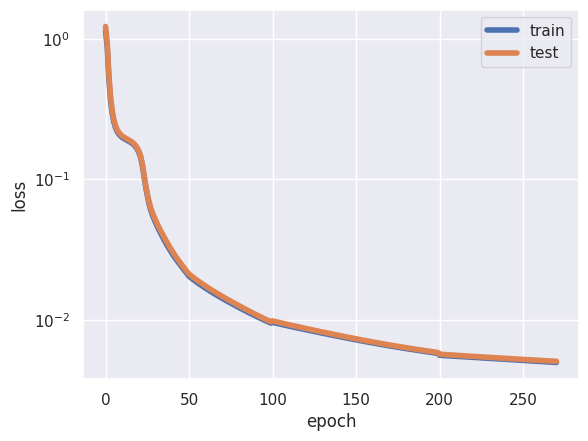

In [18]:
state, loss_training, loss_test = flux_vacua_model((train_data,test_data),(train_label,test_label),epochs = 500,batch_size = 128,learning_rate = 1e-3,
                  optimizer = "adam",num_layers = 4, layer_size = 16,schedule=[50,100,200],learning_rate_schedule=[1e-3/2,1e-3/4,1e-3/10],
                  activation = "tanh",make_plot=True, input_size=4)

The behaviour of the loss function looks promising: the loss is monotonically decreasing which is of course what we are looking for.

Generally, in neural network (NN) training, the behaviour of the loss function is a crucial indicator of the model's performance and training progress. By monitoring the loss function during training, we can diagnose potential issues, understand convergence, and assess whether the model is learning effectively. Below, we discuss key aspects of the loss function's behaviour, common pitfalls to observe with caution, and strategies to avoid undesired outcomes.

In neural network (NN) training, the behaviour of the loss function is a crucial indicator of the model's performance and training progress. By monitoring the loss function during training, we can diagnose potential issues, understand convergence, and assess whether the model is learning effectively. Below, we discuss key aspects of the loss function's behaviour, common pitfalls to observe with caution, and strategies to avoid undesired outcomes.  
The general behaviour of the loss function can be broadly described as follows: 
- **Decreasing Loss:** Ideally, the loss function should decrease over training epochs as the neural network learns to approximate the target outputs. A steadily decreasing loss indicates successful training.  
- **Plateauing Loss:** If the loss stagnates and does not improve further, the model may have reached a local minimum, saddle point, or is struggling to learn effectively.  
- **Oscillating Loss:** Loss that fluctuates excessively between epochs suggests an overly large learning rate, which causes the optimiser to overshoot minima instead of converging smoothly. 
- **Increasing Loss:** An increasing loss during training may indicate issues such as an incorrect learning rate, poorly initialised weights, or data-related problems like label noise or incorrect preprocessing.  

Depending on how we change the hyperparameters above, some of these behaviours can be simulated.

Above, we also plotted the training and test loss. This allows us to observe **overfitting** and **underfitting**:
- **Overfitting:** When the training loss continues to decrease, but the test loss plateaus or begins to increase, the model is overfitting to the training data. This occurs when the network memorises training examples rather than generalising on the test data that it has not seen before.  
    - **How to Avoid:**  
        - Use **regularisation techniques** (e.g., L2 regularisation, dropout).  
        - Implement **early stopping** to halt training when the test loss stops improving.  
        - Increase the size of the training dataset, if possible.  
        - Use data augmentation to improve generalisation.  

- **Underfitting:** When both training and test losses remain high, the model is underfitting, meaning it lacks the capacity to learn the underlying patterns in the data.  
    - **How to Avoid:**  
        - Increase the **network capacity** by adding more layers or neurons.  
        - Allow the model to train for more epochs.  
        - Use a more appropriate **activation function** or **loss function** for the problem.  

Let us highlight two other prominent issues that can appear during training:
* **Sudden Spikes in Loss:** Occasional large increases in loss can occur, particularly with non-smooth activation functions or high learning rates. These spikes can destabilise training.
They are avoided by reducing the learning rate to ensure smoother convergence or using **gradient clipping** to limit large gradient updates.  
* **Slow Convergence:** If the loss decreases very slowly, the learning rate might be too small, or the optimiser may not be suitable. This is avoided by using a learning rate scheduler to adapt the learning rate during training (e.g., step decay as above, cosine annealing) or by experimenting with more advanced optimisers like **Adam** or **RMSProp**, which adapt learning rates for each parameter.

In general, best practices for loss monitoring are as follows:
1. **Visualise the Loss:** Plot the training and test losses as a function of epochs to observe trends.  
2. **Compare Training and Test Losses:** Ensure the gap between them remains minimal to detect overfitting or underfitting.  
3. **Tune Hyperparameters:** Adjust the learning rate, optimiser, and batch size to achieve stable and efficient convergence.  
4. **Use Regularisation and Scheduling:** Apply techniques like early stopping, dropout, and learning rate schedules to improve generalisation.  
5. **Align the Loss with the Task:** Ensure the loss function matches the learning objective and problem type.  

By carefully monitoring the loss function and addressing these potential issues, one can ensure effective training and avoid common pitfalls in neural network optimisation.

                       r2_score       MAE       MSE
Linear regression     -0.001376  0.675617  1.098472
Polynomial regression  0.663435  0.352223  0.324089
Random forest          0.952296  0.053763  0.018198
NN                     0.988025  0.047815  0.005519


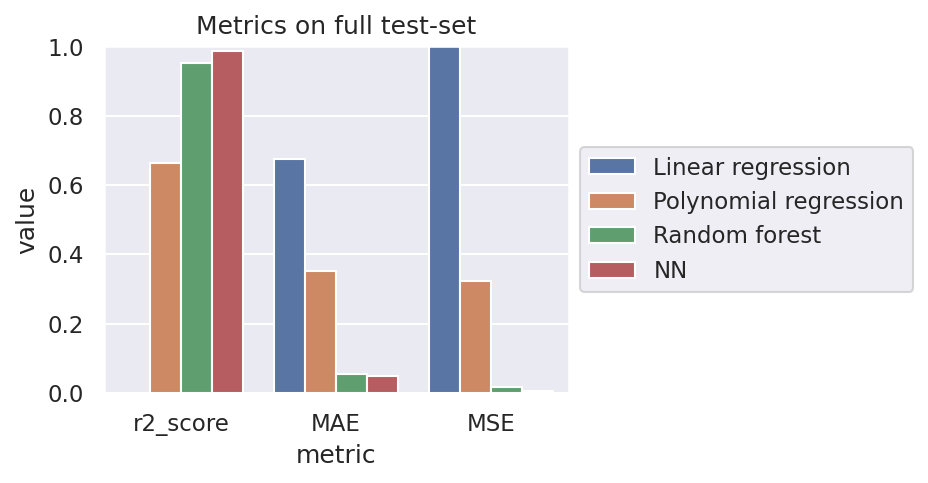

In [15]:
# Append NN to baseline models
baseline_models["NN"] = train_state_model(state)

# Evaluate metrics
baseline_evaluations = pd.DataFrame({
    metric_name: {
        model_name: metric(test_label, np.array(model.predict(test_data)))
        for model_name, model in baseline_models.items()
    }
    for metric_name, metric in metrics.items()
})

# Print output
print(baseline_evaluations)

# Plot metrics
fig = plt.figure(figsize=(4,3),dpi=150)

baseline_evaluations_tidy = (baseline_evaluations.reset_index().rename({"index": "model"}, axis=1).melt(id_vars=["model"], var_name="metric"))
sn.barplot(data=baseline_evaluations_tidy, x="metric", y="value", hue="model")

plt.ylim(0,1)
plt.title("Metrics on full test-set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Compared to our baseline models, the NN actually performs the best!

Let us also understand the performance of these four models qualitatively by plotting again the predicted value against the true value for the VEV of the axio-dilaton:

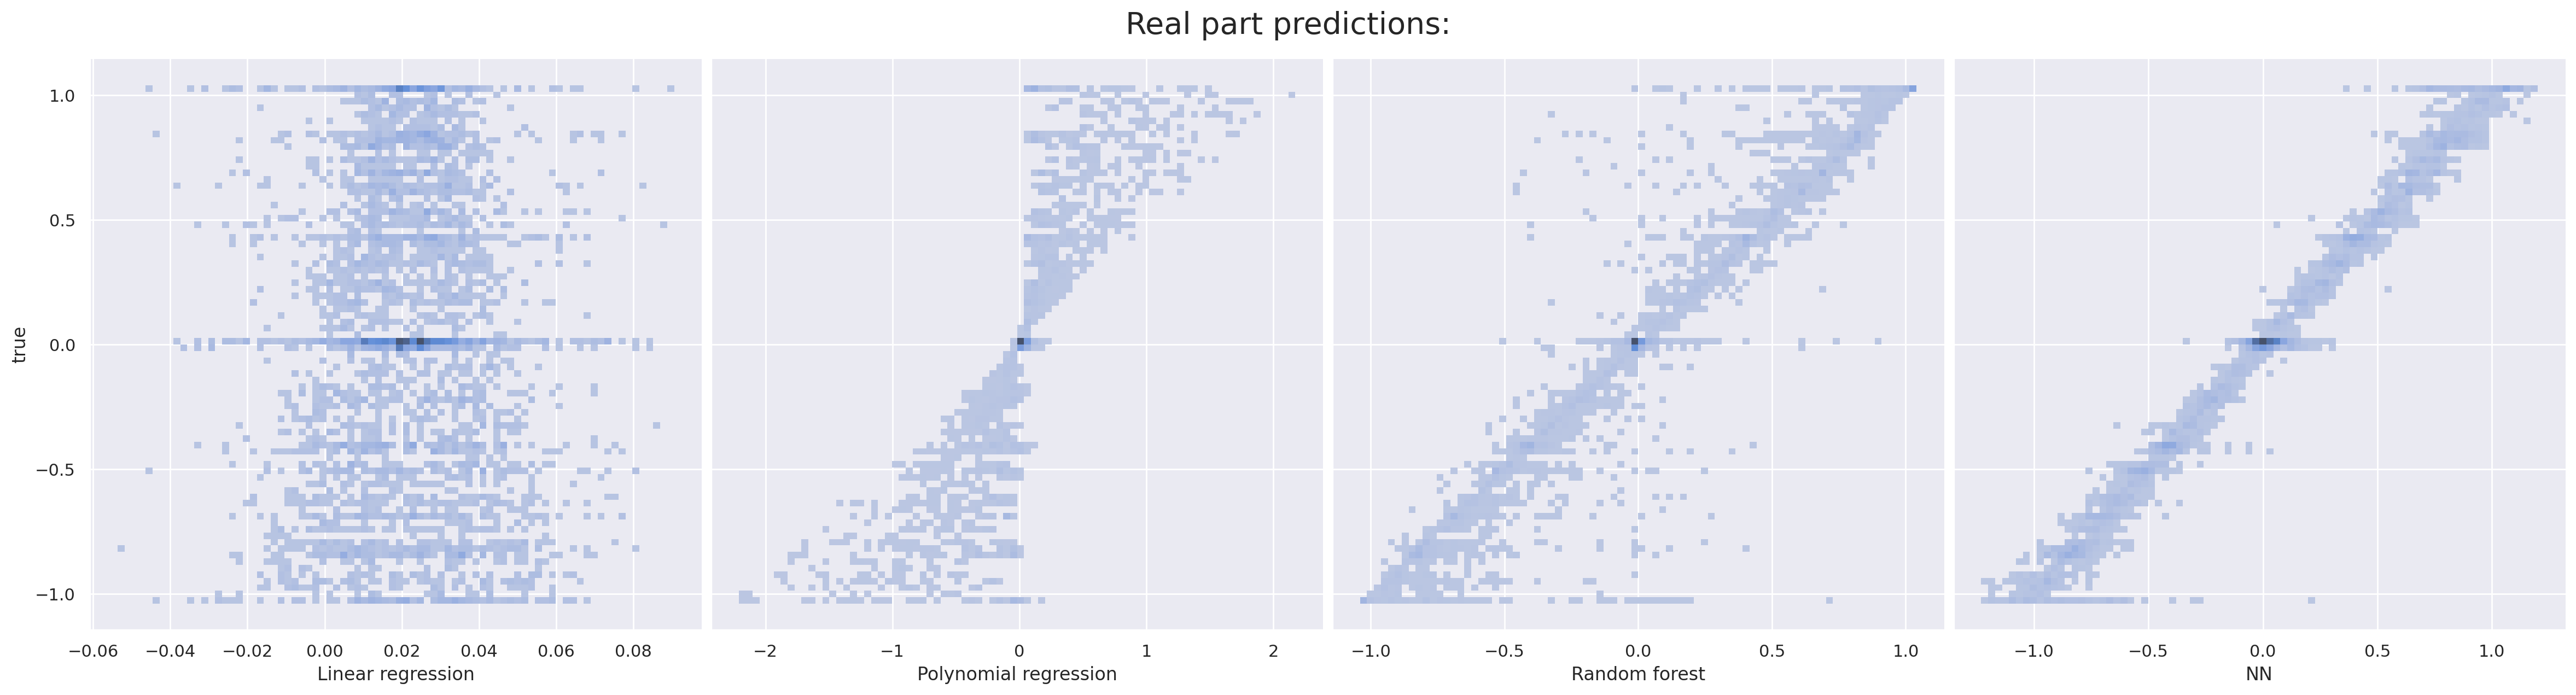

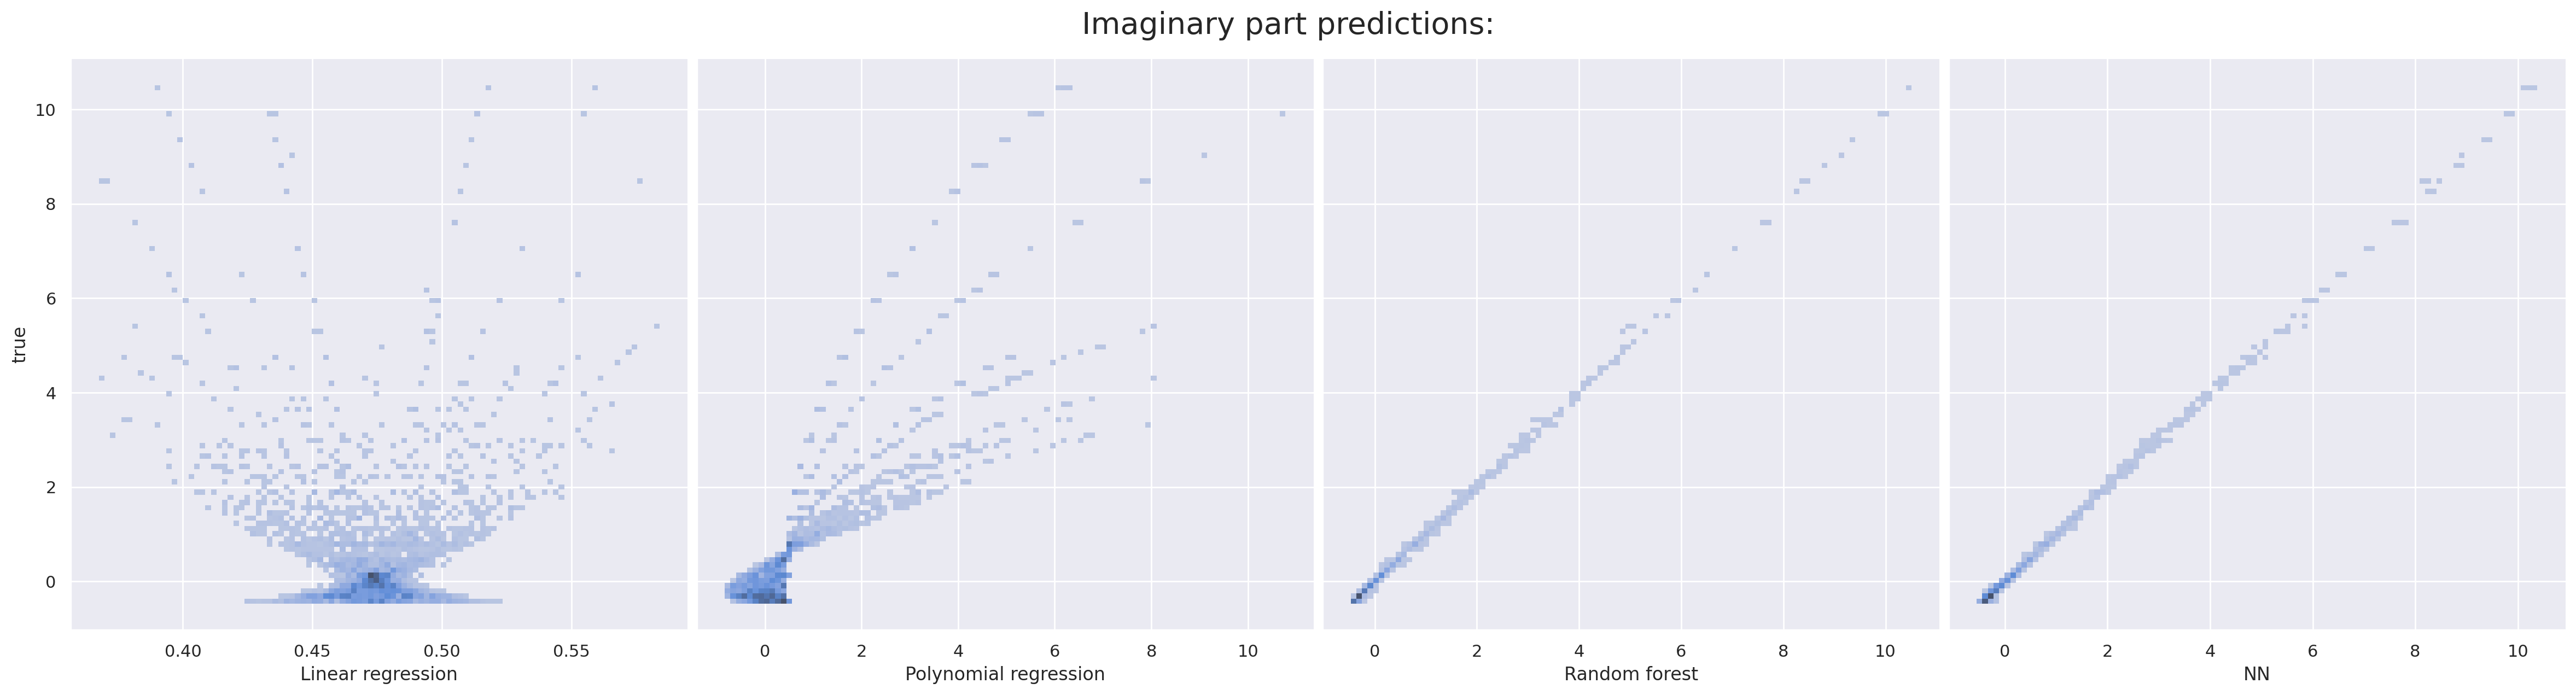

In [16]:
# Get baseline predicton for the test data -> real part
baseline_predictions_RE = pd.DataFrame({
    name: model.predict(test_data)[:,0]
    for name, model in baseline_models.items()
})

# Get baseline predicton for the test data -> imaginary part
baseline_predictions_IM = pd.DataFrame({
    name: model.predict(test_data)[:,1]
    for name, model in baseline_models.items()
})

# Add labels
baseline_predictions_RE["true"] = test_label[:,0]
baseline_predictions_IM["true"] = test_label[:,1]

g = sn.pairplot(baseline_predictions_RE, y_vars=["true"], x_vars=list(baseline_models),
                aspect=1, height=6, kind="hist", plot_kws=dict(bins=80),diag_kind=None)

g.fig.suptitle("Real part predictions:",fontsize=20, y=1.05) 

plt.show()

g = sn.pairplot(baseline_predictions_IM, y_vars=["true"], x_vars=list(baseline_models),
                aspect=1, height=6, kind="hist", plot_kws=dict(bins=100),diag_kind=None)

g.fig.suptitle("Imaginary part predictions:",fontsize=20, y=1.05)

plt.show()

Let us look at the predictions made by our Neural Network more qualitatively. First, let us collect the true and predicted values for the axio-dilaton VEV $\langle \tau\rangle$ and for the superpotential $\langle W\rangle$ (forgetting not to transform the `y`-values back to the original range)

In [17]:
# Predicted VEVs for the axio-dilaton
values = transformer_y.inverse_transform(state.apply_fn(state.params,test_data))
tau_predict = values[:,0]+1j*values[:,1]

# True VEVs for the axio-dilaton
rescaled_test_label = transformer_y.inverse_transform(test_label)
tau_true = rescaled_test_label[:,0]+1j*rescaled_test_label[:,1]

rescaled_test_data = transformer_X.inverse_transform(test_data)

# Value of the superotential for the true VEVs
W_true = vmap(W)(rescaled_test_data,tau_true)

# Value of the superotential for the predicted VEVs
W_predict = vmap(W)(rescaled_test_data,tau_predict)

Let us plot those to make a comparison

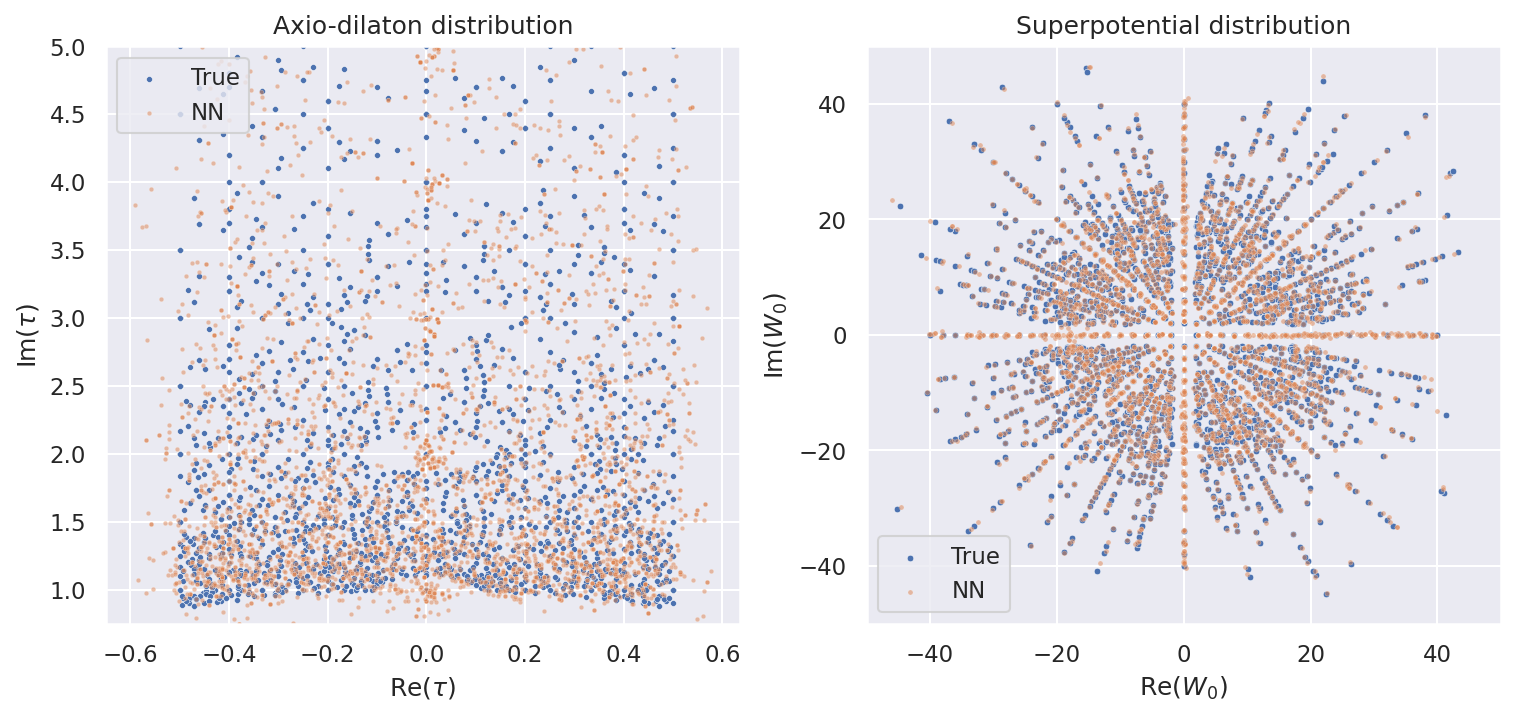

In [18]:
fig,ax = plt.subplots(1,2,figsize=(12,5),dpi=150)
alp = 0.5
Npts = 10**5 # Number of pts to plot
sn.scatterplot(x = rescaled_test_label[:Npts,0], y = rescaled_test_label[:Npts,1],ax=ax[0],s=8,alpha=alp*2,label="True")
sn.scatterplot(x = values[:Npts,0], y = values[:Npts,1],ax=ax[0],s=5,alpha=alp,label="NN")
sn.scatterplot(x = W_true.real[:Npts], y = W_true.imag[:Npts],ax=ax[1],s=10,alpha=alp*2,label="True")
sn.scatterplot(x = W_predict.real[:Npts], y = W_predict.imag[:Npts],ax=ax[1],s=6,alpha=alp,label="NN")
ax[0].set_ylim(0.75,5)
ax[1].set_ylim(-50,50)
ax[1].set_xlim(-50,50)
ax[0].set_xlabel(r"$\mathrm{Re}(\tau)$")
ax[0].set_ylabel(r"$\mathrm{Im}(\tau)$")
ax[1].set_xlabel(r"$\mathrm{Re}(W_0)$")
ax[1].set_ylabel(r"$\mathrm{Im}(W_0)$")
ax[0].set_title("Axio-dilaton distribution")
ax[1].set_title("Superpotential distribution")
plt.show()

We observe that the neural network (NN) makes reasonable predictions for the vacuum expectation values (VEVs) of the axio-dilaton as well as for the superpotential. However, the performance can likely be improved through several key steps:  

**Improving Neural Network Predictions**
1. **Optimise Hyperparameters**:  
   The current NN is trained with a single set of hyperparameters, which may not be optimal. As discussed earlier, hyperparameter optimisation is a systematic process that can lead to better performance by fine-tuning parameters such as the learning rate, batch size, number of hidden layers, and dropout rates. We will address this process below.  
   - **Why is this crucial?**: Hyperparameter optimisation ensures that the NN can converge efficiently during training, minimising errors and improving generalisation to unseen data. For physical problems like predicting VEVs, where high precision is required, suboptimal hyperparameters could lead to significant deviations from true values.  
   - **Further reading**:  
     - [Hyperparameter Tuning for Neural Networks](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/)  
     - [Advanced Hyperparameter Tuning Techniques](https://optuna.org).  

---

2. **Change Architecture**:  
   While we will explicitly experiment with architectural modifications later, the code provided in `./code/NNs_flax.py` is designed to be easily adaptable. This allows us to test alternative architectures, such as varying the number of layers, units per layer, or activation functions.  
   - **Why is this crucial?**: The architecture of the NN determines its capacity to model complex functions. For example, increasing the number of layers can improve the network's ability to approximate intricate relationships in high-dimensional data, but it may also lead to overfitting if not paired with regularisation techniques like dropout.  
   - **Potential Modifications**:  
     - Experimenting with deeper architectures for more expressive power.  
     - Testing different activation functions (e.g., ReLU, tanh, or Leaky ReLU) to see which performs better in capturing the nonlinearities of the problem.  
     - Implementing residual connections (as in ResNets) for deeper networks to avoid vanishing gradients.  
   - **Further reading**:  
     - [Designing Neural Network Architectures](https://cs231n.github.io/neural-networks-1/#arch).  
     - [A Survey on Neural Network Architectures](https://arxiv.org/abs/1905.11946).  

---

3. **Use a Numerical Optimiser to Find True VEVs**:  
   To complement the NN's predictions, we can use a numerical optimiser to find the true VEVs of the axio-dilaton, especially if analytic solutions are unknown. This approach involves solving the underlying equations governing the system directly, using methods such as gradient-based optimisation or global optimisation techniques.  
   - **Why is this crucial?**: Neural networks approximate solutions but may not always yield exact results. Numerical optimisation can provide a ground truth or refine the NN's predictions, especially for problems where exact VEVs are critical for subsequent calculations (e.g., in string compactifications or flux vacua).  
   - **Potential Methods**:  
     - Gradient-based methods like BFGS or L-BFGS for smooth optimisation landscapes.  
     - Global optimisation techniques like Simulated Annealing or Differential Evolution for complex or non-convex problems.  
     - Combining the NN with numerical optimisation in a hybrid approach, where the NN provides a good initial guess to speed up convergence.  
   - **Further reading**:  
     - [SciPy Optimisation Documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html).  
     - [Global Optimisation Techniques](https://en.wikipedia.org/wiki/Global_optimization).  
     - [Applications of Optimisation in Physics](https://arxiv.org/abs/1907.07529).  

---

**Summary**
To improve the performance of the NN and achieve more accurate predictions for the VEVs and superpotential, we will:  
- Optimise hyperparameters systematically.  
- Experiment with alternative NN architectures.  
- Leverage numerical optimisation to find true VEVs, either as a standalone approach or in conjunction with the NN.  

These steps will allow us to better explore the landscape of axio-dilaton vacua, providing insights into the interplay between machine learning and physics-driven numerical methods.

#### Hyperparameter optimisation

Above, we essentially ran a single training instance with one choice of hyperparameters. While the performance appeared promising, the **mean squared errors** (MSE) for the neural network’s predictions remain relatively large. To address this, we must undertake a process known as **hyperparameter optimisation**. 

---

**What is Hyperparameter Optimisation and why is it crucial?**

Hyperparameter optimisation involves systematically tuning the hyperparameters of a neural network to improve its performance. Hyperparameters are the settings that control the learning process and the model architecture, and they are not updated during training. Examples of hyperparameters include:
- **Learning rate**: Determines the step size during optimisation.  
- **Batch size**: Controls the number of samples processed before updating the model.  
- **Number of layers and units per layer**: Affects the complexity and capacity of the neural network.  
- **Activation functions**: Define the non-linear transformations applied to the data at each layer.  
- **Dropout rate**: Regulates regularisation by randomly deactivating neurons during training to prevent overfitting.  
- **Weight initialisation**: Influences how the optimisation process begins, affecting convergence.

By exploring different combinations of these hyperparameters, we can find configurations that lead to better training outcomes and generalisation to unseen data.

Hyperparameter optimisation is essential for several reasons:
1. **Improved Model Accuracy**: Poorly chosen hyperparameters can lead to suboptimal models, even if the architecture is theoretically sound. Optimisation helps identify settings that minimise errors such as the MSE in our case.  
2. **Preventing Overfitting or Underfitting**: The right hyperparameters strike a balance between model complexity and generalisation, avoiding issues like overfitting (too complex) or underfitting (too simple).  
3. **Efficient Training**: Certain hyperparameter settings, such as an appropriate learning rate, can accelerate convergence, saving time and computational resources.  
4. **Understanding the Model’s Sensitivity**: Exploring hyperparameter configurations provides insights into how sensitive the model is to changes in its settings, which can inform future experimentation.

For theoretical physicists, where neural networks are often applied to challenging problems such as high-dimensional function approximations, variational methods, or solving differential equations, fine-tuning hyperparameters is critical to achieving meaningful results.

---

**Manual vs. Automated Hyperparameter Optimisation**

In this part, we will perform **manual hyperparameter optimisation**, where we define and evaluate different configurations by hand. This approach is useful for gaining intuition about how specific hyperparameters influence performance. However, it can be time-consuming and computationally expensive, especially when dealing with a large number of hyperparameters or complex models. It is recommended to use more automated procedures like the ones implemented in [`optuna`](https://optuna.org).

Several Python libraries are available to automate the hyperparameter search process:
- **Grid Search**: Exhaustively searches through a predefined set of hyperparameter values. A popular implementation can be found in [Scikit-learn’s GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).  
- **Random Search**: Randomly samples hyperparameters from a defined distribution, often more efficient than grid search for high-dimensional spaces. See [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).  
- **Bayesian Optimisation**: Models the objective function probabilistically and uses this model to find optimal hyperparameters efficiently. An excellent library for this is [Scikit-Optimise](https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html).  
- **Optuna**: A flexible and powerful library for hyperparameter tuning using modern techniques such as pruning. See [Optuna](https://optuna.org).  
- **Ray Tune**: A scalable library for hyperparameter optimisation on distributed systems. See [Ray Tune](https://docs.ray.io/en/latest/tune/index.html).  

For larger projects or computationally expensive models, these tools can save significant time and effort.

---


**Further Resources for Hyperparameter Optimisation**

For those interested in learning more about hyperparameter tuning and its applications, consider the following resources:
- [A Practical Guide to Hyperparameter Optimisation](https://arxiv.org/abs/1803.09820)  
- [Deep Learning Hyperparameter Tuning](https://towardsdatascience.com/hyperparameter-tuning-c5619e7e6624)  
- [Neural Network Hyperparameters Explained](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)  


By systematically exploring the hyperparameter space, we can significantly improve the performance of our neural network and gain deeper insights into its behaviour. This process is not only essential for optimising results but also for developing a more intuitive understanding of the interplay between different hyperparameters and the model's performance.

To begin the optimisation process, let us generate a list of hyperparameter configurations to evaluate. Some examples of configurations we might consider include:

In [ ]:
# hyperparameters to test

## Layer size
layer_sizes = [2**n for n in [4,5]]

## Activations
activiations = ["tanh","relu","sigmoid"]

## Number of layers
num_dense_layers = [4,6]

## Learning rate
learning_rates = [1e-2/2**n for n in [2,4]]

## Batch size
batch_sizes = [256,512]

## Optimizers
optimizers = ["adam","sgd"]

# create a list of all combinations of hyperparameters
hyperparameters = list(itertools.product(layer_sizes, activiations, num_dense_layers,learning_rates,batch_sizes,optimizers))

len(hyperparameters),hyperparameters[:4]

Each row in the list `hyperparameters` corresponds to one particular choice of hyperparameters. 
In total, we have selected here (only) 96, though in general one should allow for more choices.

Before we start, let us generate an output directory:

In [ ]:
output_directory = path_files+'NN_run/hyperparameter_tuning_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.csv'

with open(output_directory, 'w') as f:
    f.write('layer_size,activiation,num_dense_layers,learning_rate,batch_size,optimiser,val_loss_1,val_loss_2,val_loss_3,epochs_1,epochs_2,epochs_3\n')

Now we are ready to perform the run over hyperparamters. This can take several hours depending on the above input:

In [ ]:
if False:
    # Number of trainings to perform for each choice of hyperparameters
    num_trials = 3

    # test the model for each combination of hyperparameters
    for i in tqdm(hyperparameters):

        try:
            val_losses, model_epochs = [], []

            for trial in range(num_trials):

                train_data, test_data, train_label, test_label = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(1000))

                _, _,losses = flux_vacua_model((train_data,test_data),(train_label,test_label),epochs = 500,batch_size = i[4],
                                                learning_rate = i[3], optimizer=i[5],num_layers =  i[2], 
                                                layer_size = i[0],activation = i[1], input_size = 4, print_progress=False)

                min_loss_index = losses.index(min(losses))

                val_losses.append(losses[min_loss_index])
                model_epochs.append(min_loss_index+1)

            #store the output in a csv file
            sorted_losses = sort_lists_together(val_losses, model_epochs)

            with open(output_directory, 'a') as f:

                str_write = str(i[0]) + ',' + str(i[1]) + ',' + str(i[2]) + ',' + str(i[3]) + ',' + str(i[4]) + ',' + str(i[5]) + ','
                for j in range(len(sorted_losses[0])):
                    str_write = str_write + str(sorted_losses[0][j])

                for j in range(len(sorted_losses[1])):
                    str_write = str_write + str(sorted_losses[1][j])

                f.write(str_write + '\n')

        except KeyboardInterrupt:
            sys.exit()
        except ValueError:
            # some hyperparameter combinations are not possible due to the reduced output size of the convolutions
            print('model with hyperparameters:', i, 'absurd')


The above code runs for several hours on a Laptop for the given input parameters.

In interest of time, we will load one output file that was generated earlier:

In [16]:
output_directory = path_files+"NN_run/hyperparameter_tuning_20241214-131907.csv"
df = pd.read_csv(output_directory).drop(['Unnamed: 0'],axis=1)
df

layer_size activiation  num_dense_layers  learning_rate  batch_size  \
0           16        tanh                 4       0.002500         256   
1           16        tanh                 4       0.002500         256   
2           16        tanh                 4       0.002500         512   
3           16        tanh                 4       0.002500         512   
4           16        tanh                 4       0.000625         256   
..         ...         ...               ...            ...         ...   
91          32     sigmoid                 6       0.002500         512   
92          32     sigmoid                 6       0.000625         256   
93          32     sigmoid                 6       0.000625         256   
94          32     sigmoid                 6       0.000625         512   
95          32     sigmoid                 6       0.000625         512   

   optimiser  val_loss_1  val_loss_2  val_loss_3  epochs_1  epochs_2  epochs_3  
0       adam    0.002530    0.002637    0.002488       500       500       497  
1        sgd    0.100558    0.117039    0.094062       500       500       500  
2       adam    0.003566    0.005768    0.003544       500       500       500  
3        sgd    0.242411    0.243072    0.206673       500       500       500  
4       adam    0.008752    0.010694    0.007575       500       500       500  
..       ...         ...         ...         ...       ...       ...       ...  
91       sgd    1.571400    1.654034    1.334024       492       498         6  
92      adam    0.095069    0.105129    0.076605       500       500       500  
93       sgd    1.637700    1.748048    1.628066        62       318        60  
94      adam    0.107933    0.146609    0.087922       500       500       500  
95       sgd    1.546317    1.718317    1.472592        25       134       184  

[96 rows x 12 columns]

The data is stored in a so-called [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) which is a useful
tool to stored and visualise data, especially for large datasets.
Each column above corresponds to one of the hyperparameters, the loss, or corresponding epoch respectively.

To find the result with the smallest value for the loss, we can compute the mean over the three trial runs performed for each choice:

In [ ]:
df["val_loss"] = (df["val_loss_1"]+df["val_loss_2"]+df["val_loss_3"])/3
df[df["val_loss"]<1e-3]

This allows us to make a more educated choice for suitable hyperparameters for training.

It is also interesting to look at the correlations in a plot. To do so, let us first group the hyperparameters into lists:

In [ ]:
#group the hyperparameters by the different dependencies
layer_size_dependencies = group_tuples_by_index(hyperparameters, 0)
activiation_dependencies = group_tuples_by_index(hyperparameters, 1)
num_dense_layers_dependencies = group_tuples_by_index(hyperparameters, 2)
learning_rate_dependencies = group_tuples_by_index(hyperparameters, 3)
batch_size_dependencies = group_tuples_by_index(hyperparameters, 4)
optimiser_size_dependencies = group_tuples_by_index(hyperparameters, 5)

dependencies = [layer_size_dependencies,activiation_dependencies,num_dense_layers_dependencies,learning_rate_dependencies,batch_size_dependencies, optimiser_size_dependencies]
string_dependencies = ['layer_size','activiation','num_dense_layers','learning_rate','batch_size','optimiser']

Let us plot the resulting behaviour below

In [ ]:
# read the data that we generated in the previous steps
with open(output_directory, 'r') as f:
    reader = csv.reader(f)
    data = list(reader)

data = data[1:]

data_dict = {}
for i in data:
    data_dict[(int(i[1]), str(i[2]), int(i[3]), float(i[4]), int(i[5]), str(i[6]))] = np.mean([float(i[7]), float(i[8]), float(i[9])])

    
#making plots of the final losses
for dependency in range(len(dependencies)): #track the effect of each hyperparameter
    dependency_keys = list(dependencies[dependency].keys())

    #if dependency == 2: #the number of conv layers is a special case, beacause that is what we identified as the most important hyperparameter
    dependency_keys_1 = dependency_keys[:4]
    dependency_keys_2 = dependency_keys[4:]

    fig = plt.figure(figsize=(6,4),dpi=150)
    for i in dependency_keys_1:
        x = []
        y = []
        for j in dependencies[dependency][i]:
            try:
                x.append(j[dependency])
                y.append(data_dict[j])
            except KeyError:
                x = x[:-1]
                continue
        if len(y) > 0:
            plt.plot(x, y, label = str(i))
    plt.title('Effect of ' + string_dependencies[dependency])
    plt.xlabel(string_dependencies[dependency])
    plt.ylabel('val_loss')
    plt.yscale("log")
    plt.legend()

    for i in dependency_keys_2:
        x = []
        y = []
        for j in dependencies[dependency][i]:
            try:
                x.append(j[dependency])
                y.append(data_dict[j])
            except KeyError:
                x = x[:-1]
                continue
        if len(y) > 0:
            plt.plot(x, y, alpha = 0.2)

    plt.savefig("./NN_run/figs/"+string_dependencies[dependency] + '.png', dpi = 200)
    plt.show()
    plt.close()

## 2. Learning superpotential value

String vacua encode values of key observables, such as particle masses, coupling constants, and cosmological parameters. Extracting these values from the intricate structure of the landscape, however, poses a significant computational challenge due to the high dimensionality and complexity of the parameter space. NNs offer a powerful and efficient means of addressing this challenge. By training on data sets derived from flux compactifications, NNs can learn to predict physical observables directly from the flux and geometric inputs of a given vacuum configuration. Unlike traditional approaches, which often rely on explicit analytic formulae or computationally intensive numerical methods, NNs excel at approximating the highly nonlinear and multi-variable relationships inherent in the string landscape. This makes them particularly well-suited to tasks where the direct computation of observables is prohibitive.

One of the key advantages of using NNs in this context is their ability to generalise. Once trained on a representative subset of flux vacua, an NN can make accurate predictions for unseen configurations, dramatically reducing the computational burden associated with exploring the landscape. Moreover, neural networks can handle noisy or incomplete data, providing robust approximations even in cases where the input space is not fully mapped. These qualities make NNs an indispensable tool for theoretical physicists aiming to connect the vast string landscape with low-energy phenomenology.

This introduction outlines the application of NNs to the problem of learning physical observables in the flux vacua of the string landscape. We will discuss how these ML models can be trained on flux configurations to predict key physical quantities and explore the potential of NNs to accelerate research in string phenomenology. By integrating NNs into the study of the string landscape, we open new avenues for understanding the bridge between fundamental theory and observable physics.

### Training and test data

We want to prepare the data

In [ ]:
X = fluxes
y = np.append([W_values.real],[W_values.imag],axis=0).T
X.shape, y.shape

As before, it is good practice to rescale both the inputs and outputs accordingly:

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

transformer = RobustScaler()
transformer_X = transformer.fit(X)
X = transformer_X.transform(X)

transformer = RobustScaler()
transformer_y = transformer.fit(y)
y = transformer_y.transform(y)

We then split the data into a training and test set as before:

In [ ]:
train_data, test_data, train_label, test_label = train_test_split(X, y, test_size=0.2, random_state=0)

print("Length data set:",len(X))
print("Length training data set:",len(train_data))
print("Length test data set:",len(test_data))

Below, these two sets will be used for training and subsequent evaluation of the performance of our architectures.

### Baseline model testing

Let us run through the same baseline model testing as above:

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures


# Get quadratic polynomial features
poly_features = PolynomialFeatures(degree=2, include_bias=False)

# Build custom class for polynomial regression
class poly_reg(LinearRegression):
    
    def __init__(self):
        
        super(poly_reg, self).__init__()
        
        self.linear_regression = LinearRegression()
        
    def predict(self,data):
        
        return self.linear_regression.predict(poly_features.fit_transform(data))
    
    def fit(self,data,labels):
        
        return self.linear_regression.fit(poly_features.fit_transform(data),labels)


# Collect models from `sklearn`
baseline_models = {
    'Linear regression': LinearRegression(),
    'Polynomial regression': poly_reg(),
    'Random forest': RandomForestRegressor(),
} 

We are now ready to fit the above models to our data

In [ ]:
# Fit the models on training data
for name, model in tqdm(baseline_models.items()):
    model.fit(train_data, train_label)

Get predictions for test data

In [ ]:
# Get baseline predicton for the test data
baseline_predictions_RE = pd.DataFrame({
    name: model.predict(test_data)[:,0]
    for name, model in baseline_models.items()
})

baseline_predictions_IM = pd.DataFrame({
    name: model.predict(test_data)[:,1]
    for name, model in baseline_models.items()
})

baseline_predictions_RE["true"] = test_label[:,0]
baseline_predictions_IM["true"] = test_label[:,1]

Evaluate metrics

In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
metrics = {
    'r2_score': r2_score,
    'MAE': mean_absolute_error,
    'MSE': mean_squared_error,
    
}

baseline_evaluations = pd.DataFrame({
    metric_name: {
        model_name: metric(test_label, model.predict(test_data))
        for model_name, model in baseline_models.items()
    }
    for metric_name, metric in metrics.items()
})


print(baseline_evaluations)
fig = plt.figure(figsize=(4,3),dpi=150)

baseline_evaluations_tidy = (
    baseline_evaluations
    .reset_index()
    .rename({"index": "model"}, axis=1)
    .melt(id_vars=["model"], var_name="metric")
)
sn.barplot(data=baseline_evaluations_tidy, x="metric", y="value", hue="model")
plt.ylim(0, 1)
plt.title("Metrics on full test-set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The metrics quantify how well the different models do in solving the task at hand. As expected, linear regressions fails miserably because 
the function that we are trying to learn is simply non-linear. In contrast, random forest works splendidly with small MSE and high r2-score.

There is also a qualitative way to evluate the performance of the different models. Namely, we can plot the predicted values 
against the true values and in this way, see the qualitative differences in our baseline models:

In [ ]:
g = sn.pairplot(
    baseline_predictions_RE,
    y_vars=["true"],
    x_vars=list(baseline_models),
    aspect=1,
    height=6,
    kind="hist",
    plot_kws=dict(bins=80),diag_kind=None,
)

g.fig.suptitle("Real part predictions:",fontsize=20, y=1.05) 

plt.show()

g = sn.pairplot(
    baseline_predictions_IM,
    y_vars=["true"],
    x_vars=list(baseline_models),
    aspect=1,
    height=6,
    kind="hist",
    plot_kws=dict(bins=100),diag_kind=None,
)


g.fig.suptitle("Imaginary part predictions:",fontsize=20, y=1.05)

plt.show()

### Training an NN architecture for values of $\langle W\rangle$

We are using here exactly the same NN implemetation as above:

In [ ]:
seed = 42
rns_key = PRNGSequence(seed)

state, loss_training, loss_model = flux_vacua_model((train_data,test_data),(train_label,test_label),epochs = 500,batch_size = 128,learning_rate = 1e-3,
                  optimizer="adam",num_layers = 4, layer_size = 16,schedule=[50,100,200],learning_rate_schedule=[1e-3/2,1e-3/4,1e-3/10],
                  activation = "tanh",make_plot=True, input_size=4,rns_key=rns_key)

We evaluate the performance by computing again the metrics:

In [ ]:
# Append NN to baseline models
baseline_models["NN"] = train_state_model(state)

# Evaluate metrics
baseline_evaluations = pd.DataFrame({
    metric_name: {
        model_name: metric(test_label, np.array(model.predict(test_data)))
        for model_name, model in baseline_models.items()
    }
    for metric_name, metric in metrics.items()
})

# Print output
print(baseline_evaluations)

# Plot metrics
fig = plt.figure(figsize=(4,3),dpi=150)

baseline_evaluations_tidy = (baseline_evaluations.reset_index().rename({"index": "model"}, axis=1).melt(id_vars=["model"], var_name="metric"))
sn.barplot(data=baseline_evaluations_tidy, x="metric", y="value", hue="model")

plt.ylim(0,1)
plt.title("Metrics on full test-set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We clearly see that the NN beats the other models by some margin. However, depending on the application in mind, 
the overall improvement compared to Random Forest is only marginal. It might vary from application to application 
whether it is worth going through this extensive training process for the NN to find <1% improvement on the MSE. 

We can again plot the qualitative performance:

In [ ]:
# Get baseline predicton for the test data
baseline_predictions_RE = pd.DataFrame({
    name: model.predict(test_data)[:,0]
    for name, model in baseline_models.items()
})

baseline_predictions_IM = pd.DataFrame({
    name: model.predict(test_data)[:,1]
    for name, model in baseline_models.items()
})

baseline_predictions_RE["true"] = test_label[:,0]
baseline_predictions_IM["true"] = test_label[:,1]

g = sn.pairplot(baseline_predictions_RE,y_vars=["true"], x_vars=list(baseline_models), 
                aspect=1, height=6, kind="hist", plot_kws=dict(bins=80),diag_kind=None)

g.fig.suptitle("Real part predictions:",fontsize=20, y=1.05) 

plt.show()

g = sn.pairplot(baseline_predictions_IM, y_vars=["true"], x_vars=list(baseline_models),
                aspect=1, height=6, kind="hist", plot_kws=dict(bins=100),diag_kind=None)

g.fig.suptitle("Imaginary part predictions:",fontsize=20, y=1.05)

plt.show()

This shows visually that the NN performs really good, especially when compared with the three baseline models that we started with!

Let us look at the predictions made by our Neural Network more qualitatively. First, let us collect the true and predicted values for the VEV of the superpotential $\langle W\rangle$ (not forgetting to rescale the outputs appropriately)

In [ ]:
# Predicted values for the superpotential
values = transformer_y.inverse_transform(state.apply_fn(state.params,test_data))
W_predict = values[:,0]+1j*values[:,1]

# True VEVs for the superpotential
rescaled_test_label = transformer_y.inverse_transform(test_label)
W_true = rescaled_test_label[:,0]+1j*rescaled_test_label[:,1]

Let us plot those to make a comparison

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,5),dpi=150)
alp = 0.5
Npts = 10**5 # Number of pts to plot
sn.scatterplot(x = W_true.real[:Npts], y = W_true.imag[:Npts],ax=ax[0],s=10,alpha=alp*2,label="True")
sn.scatterplot(x = W_predict.real[:Npts], y = W_predict.imag[:Npts],ax=ax[0],s=6,alpha=alp,label="NN")
sn.scatterplot(x = W_true.real[:Npts], y = W_true.imag[:Npts],ax=ax[1],s=10,alpha=alp*2,label="True")
sn.scatterplot(x = W_predict.real[:Npts], y = W_predict.imag[:Npts],ax=ax[1],s=6,alpha=alp,label="NN")
ax[0].set_ylim(-50,50)
ax[0].set_xlim(-50,50)
ax[1].set_ylim(-20,20)
ax[1].set_xlim(-20,20)
ax[0].set_xlabel(r"$\mathrm{Re}(W_0)$")
ax[0].set_ylabel(r"$\mathrm{Im}(W_0)$")
ax[1].set_xlabel(r"$\mathrm{Re}(W_0)$")
ax[1].set_ylabel(r"$\mathrm{Im}(W_0)$")
ax[0].set_title("Superpotential distribution")
ax[1].set_title("Superpotential distribution zoomed in")
plt.show()

## 3. Solving inverse problems with Genetic Algorithms (GAs)

As stressed many times before, the string landscape presents a vast array of possible solutions to string theory, each corresponding to a potential vacuum configuration with distinct physical properties. However, in the context of flux vacua, identifying specific flux choices that reproduce desired physical properties in the 4-dimensional EFT, such as observed particle spectra or cosmological constants, constitutes an inverse problem: starting from a set of physical requirements and working backwards to uncover the corresponding vacuum configuration.

Inverse problems in the string landscape are notoriously challenging due to the high dimensionality and complexity of the underlying parameter space. Flux compactifications involve discrete flux quanta, geometric moduli, and other parameters constrained by consistency conditions such as tadpole cancellation and supersymmetry. Navigating this vast and rugged landscape with traditional analytical or numerical methods often proves infeasible. This is where **Genetic algorithms** (GAs) emerge as a powerful and efficient approach.

Inspired by the principles of biological evolution, GAs operate by iteratively evolving a population of candidate solutions through selection, crossover, and mutation, guided by a fitness function that measures the suitability of a given candidate. In the context of flux vacua, the fitness function is designed to quantify how well a particular configuration matches the desired physical criteria. By exploiting the ability of GAs to explore diverse regions of the parameter space and converge on optimal solutions, one can identify vacua that satisfy complex constraints, even in cases where direct methods fail.

This introduction to solving inverse problems with GAs focuses on their application to flux vacua in the string landscape. We will explore how these algorithms can efficiently search for solutions in high-dimensional spaces, handle discrete and combinatorial flux choices, and navigate the intricate relationships between geometric and physical parameters. By leveraging GAs, theoretical physicists gain a versatile tool for uncovering physically relevant solutions in one of the most enigmatic corners of string theory.


First, we need to define a *target function*, that is, a function that spits out the observable that we are interested in.
Here, we simply choose string coupling $g_s$ as our target:

In [6]:
vtau_val = vmap(tau_val)
vNflux = vmap(Nflux)
vW = vmap(W)

def target(fluxes):
    r"""
    **Description:**
    
    Args:
        fluxes (Array): Input fluxes.
        
    Returns:
        Array: String coupling.
        dict: Dictionary with values of VEVs for axio-dilaton.
    """
    # Compute VEVs for axio-dilaton
    tau_values = vtau_val(fluxes)
    
    # Store VEVs in dictionary
    d = {}
    d["tau"] = tau_values
    
    # Return string coupling plus a dictionary containing the VEVs (which are stored in files).
    return 1/tau_values.imag, d

For this target, we need to define a **task**: in many applications, we rely on perturbation theory for the validity of our computations.
That implies in particular, that we require small values for all of our couplings.
In the setting here, we will therefore try **to minimise the string coupling**.

Next, we need to define a fitness function that is suitable for our task. We choose the following:

In [7]:
def fitness(features, sig=1., mu=0.):
    r"""
    **Description:**
    Computes fitness.
    
    Args:
        features (Array): Features.
        sig (float, optional): Normalisation/width of fitness.
        mu (float, optional): Mean of fitness, i.e., desired feature value.
        
    Returns:
        Array: Normalised fitness.
    """
    # Compute fitness
    fitness = sig/(features-mu+1e-10)**2
    
    # Return normalised fitness
    return fitness/np.sum(fitness)

The fitness function peaks around `mu`. To avoid dividing by zero, we added `1e-10` in the denominator.

We are now ready to run the GA. We have to make a few choices however:
* `population_size`: The size of the population to run the GA with.
* `num_generations`: Number of generations to run the GA for.
* `scale`: A multiplicative scaling factor for the number of flux chocies to generate per generation. This becomes necessary because some flux choices might either be duplicates or not satisfying the tadpole bound. Hence, they will be removed from the list. To keep the population size constant, we have to ensure that within each generation, at least `population_size` unique and consistent (here: below tadpole) flux choices are being generated.
* `max_flux`: Maximum flux value to be used.
* `Qmax`: Maximum D3-charge.
* hyperparameters: Our GA also needs some hyperaparameters to be specified. These include **LIST HERE**. We provided a functon `generate_random_hyperparameters` that determines a random choice of hyperparameters. We will comment more on the choice of hyperaparameters belows.

Now, let us run the GA:

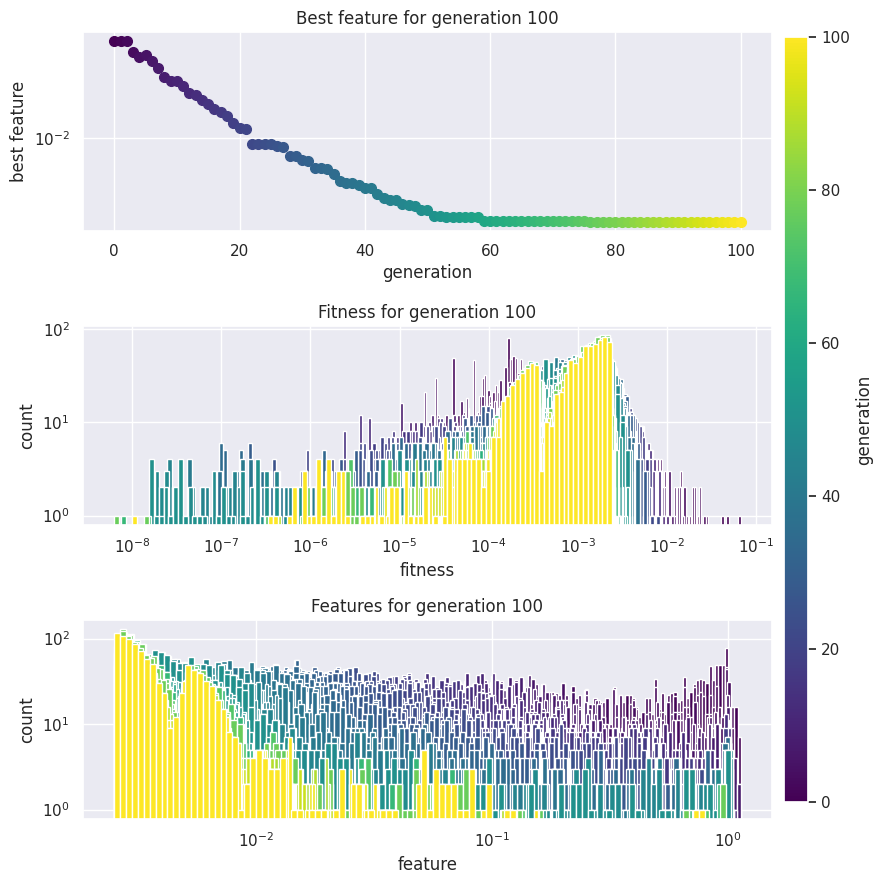

In [16]:
# Set some parameters
population_size = 1000
num_generations = 100
scale = 4
max_flux = 20
Qmax = 1000

# Get random hyperparameters
hyper_dict = generate_random_hyperparameters(population_size,num_generations, scaling_factor=scale)

# Run GA
pop,features,history = run_GA(population_size,num_generations, Qmax = Qmax, allele_bound = max_flux,
                              fitness_function = fitness, sigma=0.01, mu=0.001, update_sigma=True,
                              optimisation_target=target, hyper_dict = hyper_dict,
                              save_files=True,run_folder=path_files+"ga_run/", plot_progress=True, log_scale_plot = True)

Since the above code runs quite a few minutes, let us here load for simplicity the data from a previous run:

In [7]:
pop,features,history,feature_history = load_ga_run(path_files+"ga_run/")
history.shape

(101, 1000, 4)

We make the following general observations about the GA's evolution:
* Firstly, the GA quickly identifies small values for the string coupling during the early stages of its operation. This rapid convergence highlights the algorithm's efficiency in exploring the search space and locating solutions that minimise the coupling parameter.
* Following this initial success, the entire population's distribution progressively shifts towards smaller string coupling values. This collective movement reflects the GA's ability to exploit promising regions of the search space by favouring individuals with optimal traits, thus driving the population towards increasingly refined solutions.
* However, the GA's evolution eventually stagnates, with no further significant improvement in the string coupling. This plateau indicates that the algorithm may have reached a local optimum or exhausted its capacity to explore new solutions within the current hyperparameter configuration.

Let us point out that, even though we fixed the hyperparameters randomly, the GA did an excellent job in minimising the string coupling.
But as for NNs, one can try to optimise hyperparameters to achieve even better performance. This has e.g. been studied in [this paper](https://inspirehep.net/literature/2787060)
from earlier this year. These methods can be easily employed in our implementation here.

### Occupation number plot for GA output

To understand the strategies that the GA has been developing to find small string couling,
let us visualise the distribution of fluxes over the course of the GA's evolution:

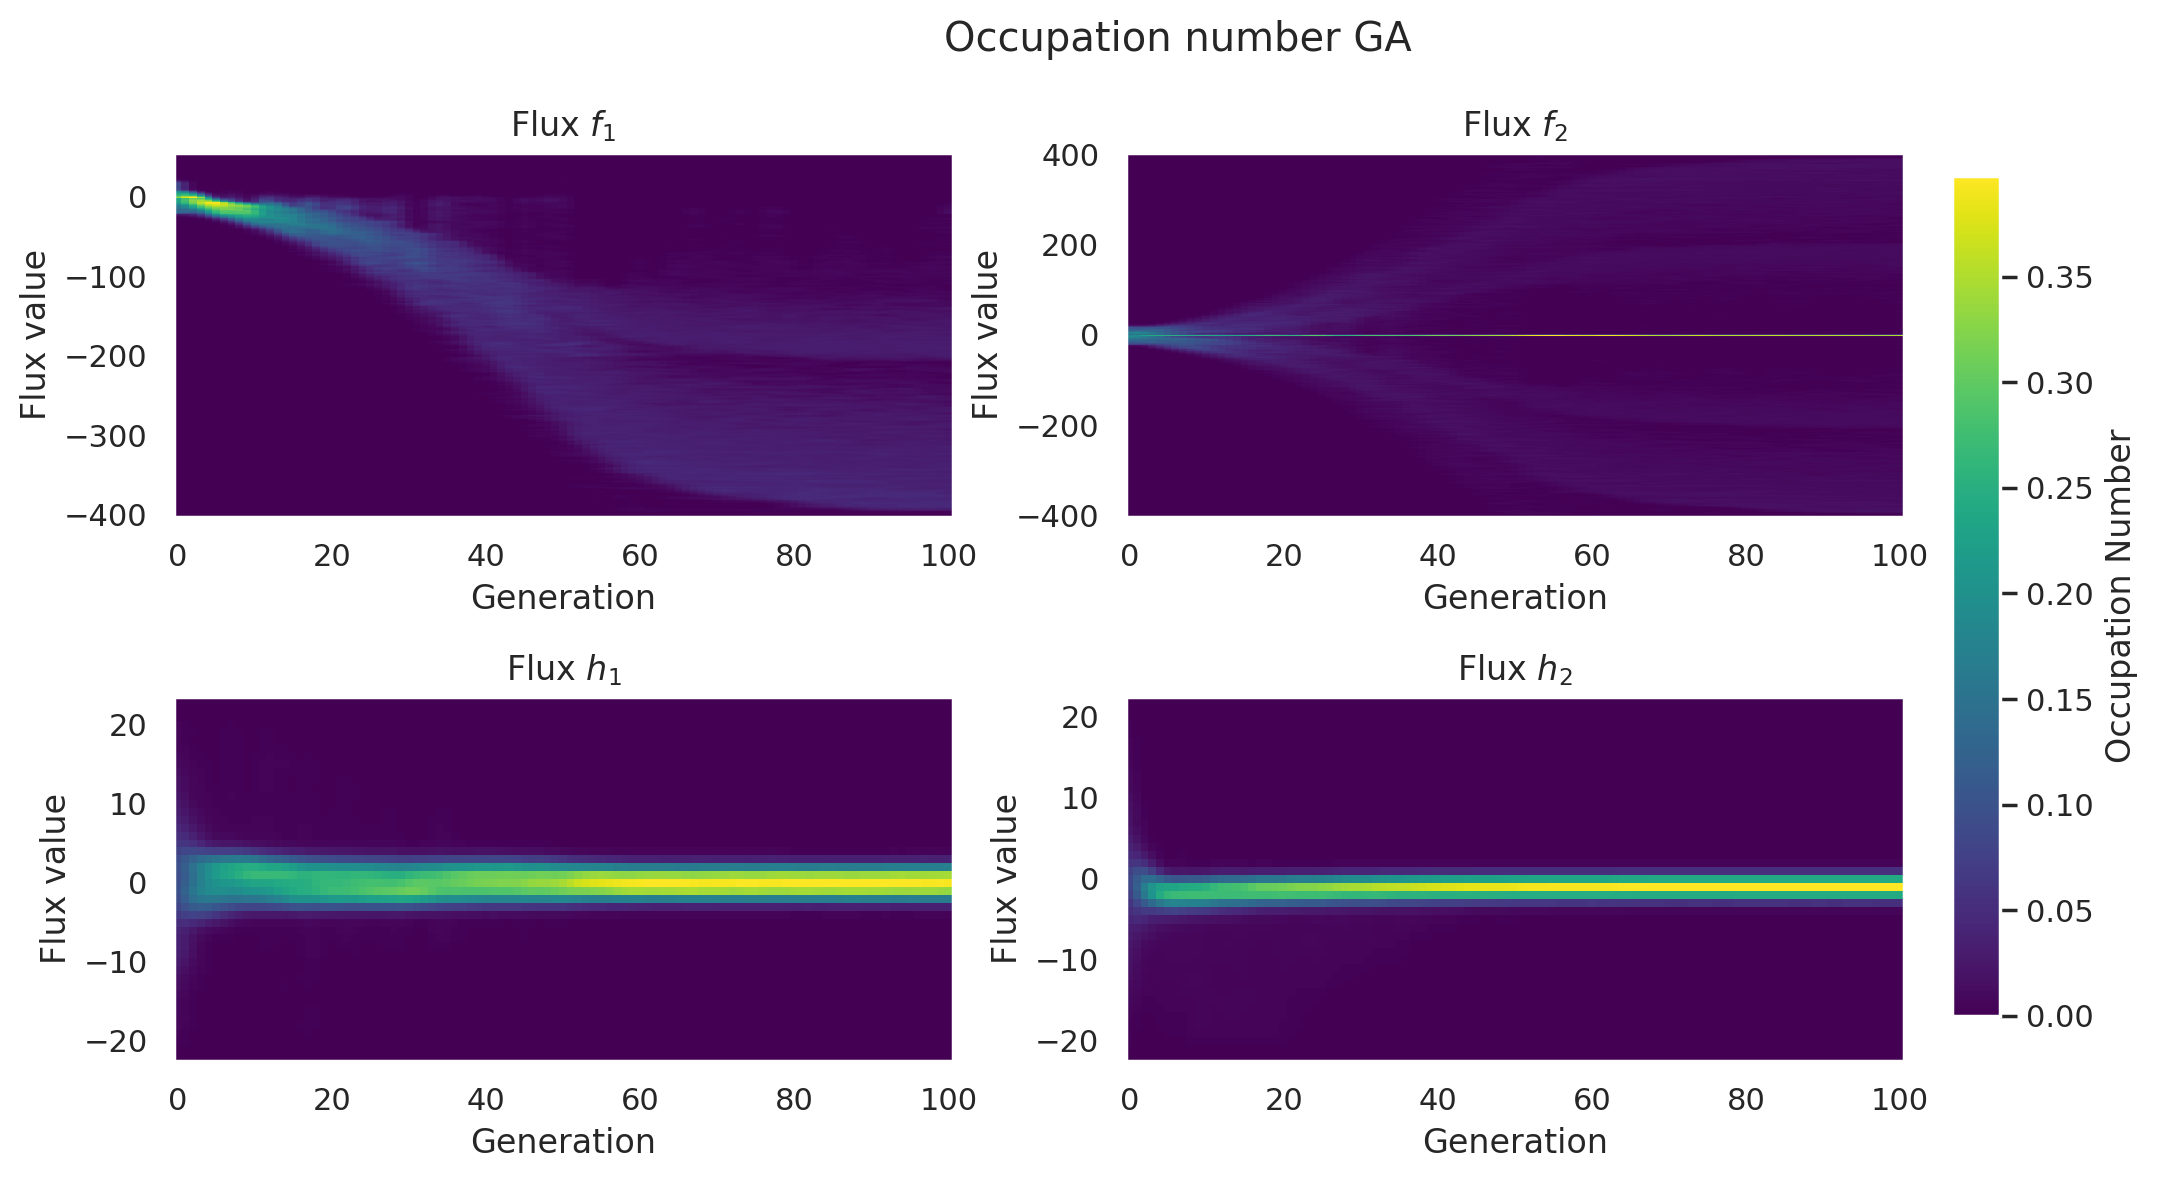

In [8]:
from scipy.ndimage import gaussian_filter

uniform_y_axis = False
generation=-1
a=0
n_gen = len(history)
fig,ax = plt.subplots(2,2,figsize=(12,6))
for i in range(2):
    for j in range(2):
        
        if uniform_y_axis:
            limits = [int(np.min(history)-2),int(np.max(history)+3)]
        else:
            if i==0:
                f = np.array(history)[:,:,j]
            else:
                f = np.array(history)[:,:,j+2]

            limits = [int(np.min(f)-2),int(np.max(f)+3)]
            
        
        d = np.zeros((limits[1]-limits[0]+1,n_gen))
        
        for l in range(n_gen):
            
            pop=history[l].T.astype(int)
            if i==0:
                test = pop[j]
            else:
                test = pop[j+2]

            labels, counts = np.unique(test, return_counts=True)
            labels+=np.abs(limits[0])
            for k in range(len(labels)):
                if labels[k]>0 and labels[k]<=limits[1]+np.abs(limits[0]):
                    d[labels[k],l]+=counts[k]/len(test)
                    
        d=gaussian_filter(d, sigma=1)
        x=ax[i][j].pcolor(range(n_gen),range(limits[0],limits[1]+1),d,cmap="viridis")
        if i == 0:
            ax[i][j].set_title(r'Flux $f_{'+str(j+1)+'}$')
        else:
            ax[i][j].set_title(r'Flux $h_{'+str(j+1)+'}$')
        ax[i][j].set_xlabel('Generation')
        ax[i][j].set_ylabel('Flux value')
        a +=1

fig.suptitle('Occupation number GA ')
fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar=fig.colorbar(x, cax=cbar_ax)
cbar.set_label('Occupation Number')
plt.savefig(path_figs+"GA_occupation_number.pdf",format="pdf",dpi=200,bbox_inches="tight")
plt.show()
plt.close()

We clearly see that, while fluxes $h_1,h_2,f_2$ are dominated by flux values close to zero (bright yelow regions), the distribution for flux $f_1$ in generations $\gtrsim 10$ is predominantly populating large (negative) values.
Recalling that
\begin{equation}
\langle\tau\rangle = \dfrac{f_1-\mathrm{i}f_2}{h_1-\mathrm{i}h_2}\quad \Rightarrow \quad 
\text{Re}(\langle\tau\rangle) = \dfrac{f_1h_1+f_2h_2}{h_1^2+h_2^2}\, ,\quad 
\text{Im}(\langle\tau\rangle) = \dfrac{f_1h_2-f_2h_1}{h_1^2+h_2^2}
\end{equation}
and thus
\begin{equation}
g_s = \dfrac{1}{\text{Im}(\langle\tau\rangle)} = \dfrac{h_1^2+h_2^2}{f_1h_2-f_2h_1}\, .
\end{equation}
By tuning $h_1,h_2$ small and $f_1$ large, the string coupling is clearly minimised and this seems to be precisely the strategy that the GA has learned.

### PCA on GA output

An interesting question concerns the effective distribution of the fluxes, in particular as they change over various generations. While we started with a completely random initial population, the final population is dominated by solutions for which the string coupling is minimised - this is what we have been aiming for.
Now, as we argued above, with higher-dimensional datasets it is always helpful to employ PCA. Here, we apply PCA to both the initial and final population and visualise the output below:

In [21]:
from sklearn.decomposition import PCA 

fluxes0 = history[0]
fluxes = history[-1]
pca = PCA()
pca.fit(fluxes)

X_trafo=pca.transform(fluxes).T
X_trafo0=pca.transform(fluxes0).T

print("Variance: ",np.round(pca.explained_variance_ratio_,2))
print("1st PC: ",np.round(pca.components_[0],2))
print("2nd PC: ",np.round(pca.components_[1],2))
print("3rd PC: ",np.round(pca.components_[2],2))
print("4th PC: ",np.round(pca.components_[3],2))

Variance:  [0.87 0.13 0.   0.  ]
1st PC:  [ 0.  1. -0. -0.]
2nd PC:  [ 1. -0.  0. -0.]
3rd PC:  [ 0.   -0.   -0.15  0.99]
4th PC:  [-0.    0.    0.99  0.15]


Then let us plot the PCA for both the initial and final population:

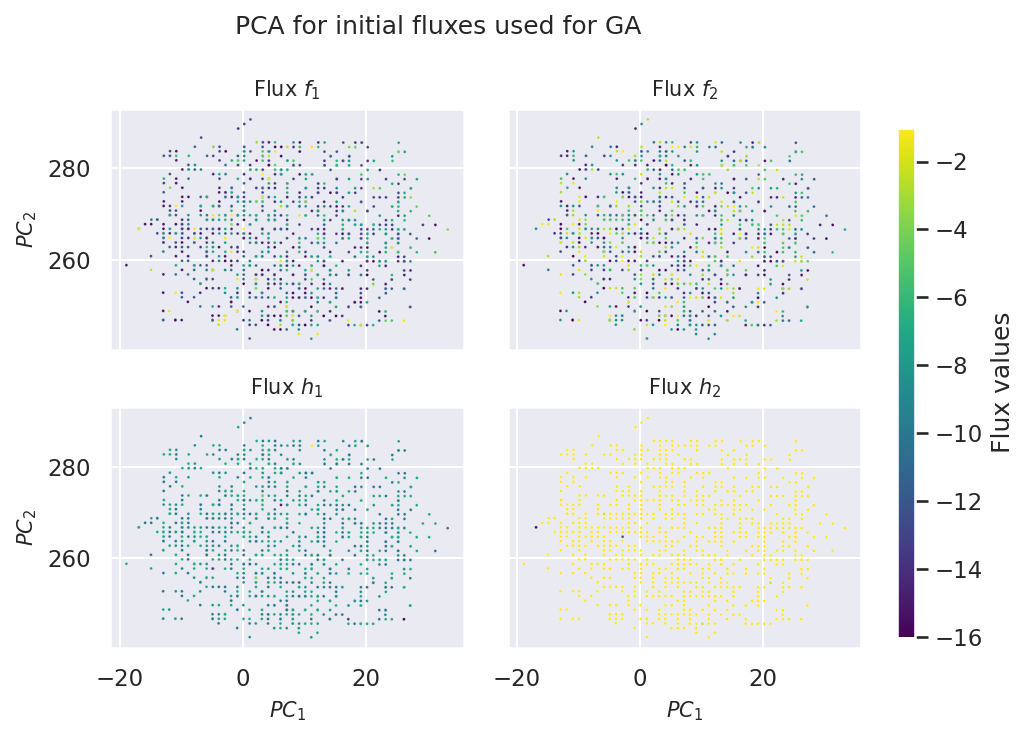

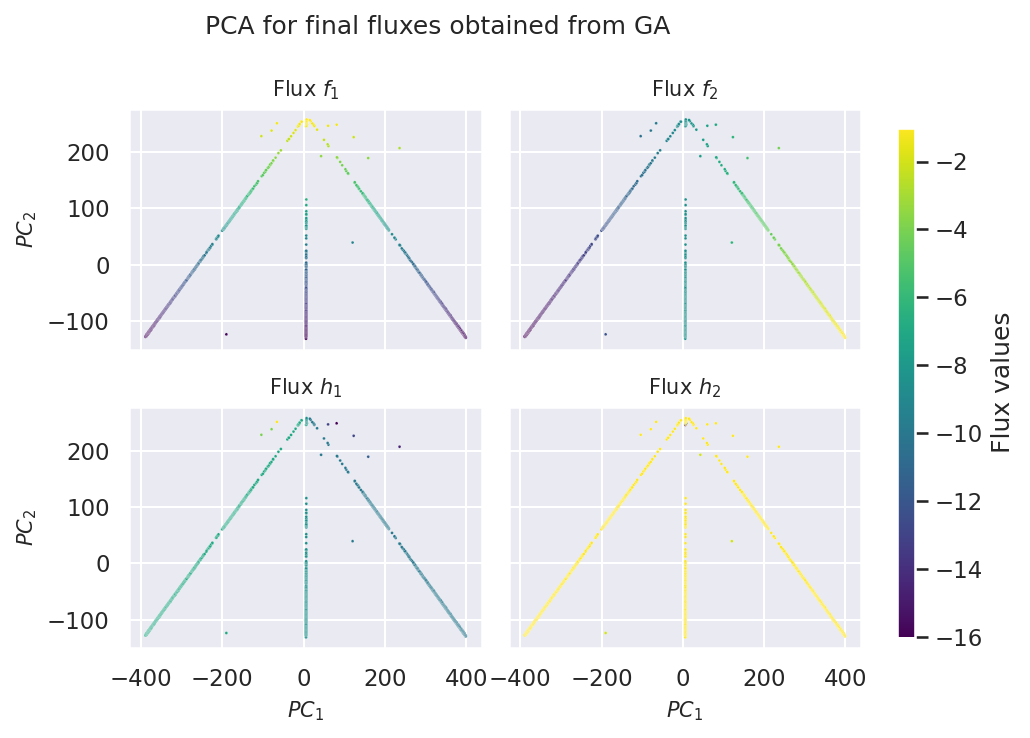

In [24]:
fig,ax = plt.subplots(2,2,figsize=(6,5),dpi=150)
for k in range(NumFluxes):
    
    flux_ID=k+1
    
    if k<2:
        I1=0
        I2=k
    else:
        I1=1
        I2=k-2
        
    sn.scatterplot(x=X_trafo0[0],y=X_trafo0[1],s=ss,c=fluxes.T[flux_ID-1],cmap=cmap,legend=False,ax=ax[I1][I2]);
    ax[I1][I2].set(xlabel='$PC_1$', ylabel='$PC_2$')
    ax[I1][I2].xaxis.get_label().set_fontsize(fss)
    ax[I1][I2].yaxis.get_label().set_fontsize(fss)
    if I1==0:
        ax[I1][I2].set_title(r'Flux $f_{'+str(I2+1)+'}$',fontsize=fsss)
    else:
        ax[I1][I2].set_title(r'Flux $h_{'+str(I2+1)+'}$',fontsize=fsss)
    
    if I1!=1:
        ax[I1][I2].set(xticklabels=[])  # remove the tick labels
        ax[I1][I2].set(xlabel=None)
    if I2!=0:
        ax[I1][I2].set(yticklabels=[])  # remove the tick labels
        ax[I1][I2].set(ylabel=None)


norm = plt.Normalize(min(fluxes.T[flux_ID-1]),max(fluxes.T[flux_ID-1]))
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)

fig.suptitle('PCA for initial fluxes used for GA',fontsize=fs)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.01, 0.15, 0.02, 0.68])
cbar=fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Flux values',fontsize=fs)

plt.tight_layout()
plt.savefig(path_figs+"PCA_GA_initial.png",format="png",dpi=200, bbox_inches='tight')
plt.show()

fig,ax = plt.subplots(2,2,figsize=(6,5),dpi=150)
for k in range(NumFluxes):
    
    flux_ID=k+1
    
    if k<2:
        I1=0
        I2=k
    else:
        I1=1
        I2=k-2
        
    sn.scatterplot(x=X_trafo[0],y=X_trafo[1],s=ss,c=fluxes.T[flux_ID-1],cmap=cmap,legend=False,ax=ax[I1][I2]);
    ax[I1][I2].set(xlabel='$PC_1$', ylabel='$PC_2$')
    ax[I1][I2].xaxis.get_label().set_fontsize(fss)
    ax[I1][I2].yaxis.get_label().set_fontsize(fss)
    if I1==0:
        ax[I1][I2].set_title(r'Flux $f_{'+str(I2+1)+'}$',fontsize=fsss)
    else:
        ax[I1][I2].set_title(r'Flux $h_{'+str(I2+1)+'}$',fontsize=fsss)
    
    if I1!=1:
        ax[I1][I2].set(xticklabels=[])  # remove the tick labels
        ax[I1][I2].set(xlabel=None)
    if I2!=0:
        ax[I1][I2].set(yticklabels=[])  # remove the tick labels
        ax[I1][I2].set(ylabel=None)


norm = plt.Normalize(min(fluxes.T[flux_ID-1]),max(fluxes.T[flux_ID-1]))
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)

fig.suptitle('PCA for final fluxes obtained from GA',fontsize=fs)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.01, 0.15, 0.02, 0.68])
cbar=fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Flux values',fontsize=fs)

plt.tight_layout()
plt.savefig(path_figs+"PCA_GA.png",format="png",dpi=200, bbox_inches='tight')
plt.show()

This is a quite spectacular outcome: compared to the PCA analysis performed on the initial (random) population of fluxes, the flux choices in the final population (for which the target corresponding here to  small string coupling, is really well approximate) seem to align with certain rays for the dominating principal components. Looking at the principal components above, we see that $PC_1\sim f_2$ and $PC_1\sim f_1$. Recalling our analytical formula for $g_s$,
\begin{equation}
g_s =  \dfrac{h_1^2+h_2^2}{f_1h_2-f_2h_1}\, ,
\end{equation}
it is clear that by tuning either $f_1$ or $f_2$ large, the string coupling becomes small which matches well with the PCA picture above.